In [1]:
# # 在导入任何库之前添加
# import os
# os.environ["TORCH_COMPILE_DEBUG"] = "1"
# os.environ["TORCH_INDUCTOR_DISABLE_CUSTOM_PASSES"] = "1"
# 首先导入 torch 及其所有子模块
import torch
import torch.nn as nn
import torch.optim as optim

# 然后导入其他库
import pandas as pd
import numpy as np
import os
import re
import json
import time
import requests
from datetime import datetime
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import platform
# 最后导入 transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from textblob import TextBlob


# 添加以下导入
try:
    from IPython.display import display, Image
    in_notebook = True
except ImportError:
    in_notebook = False

# 设置matplotlib以支持中文和保存图像
plt.rcParams['figure.max_open_warning'] = 50  # 允许更多图形
# 设置中文字体支持 - 针对Mac环境
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = ['SimHei','Arial Unicode MS']
else:  # Windows或Linux
    plt.rcParams['font.family'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

In [2]:
import pandas as pd
import numpy as np
import os
import re
import json
import time
import requests
import torch
from datetime import datetime
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

# 创建结果保存目录结构
RESULTS_DIR = "生成结果"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
    print(f"已创建结果保存目录: {os.path.abspath(RESULTS_DIR)}")
else:
    print(f"使用现有结果保存目录: {os.path.abspath(RESULTS_DIR)}")


# 设置关键词保存的文件夹
KEYWORD_DIR = os.path.join(RESULTS_DIR, "product_keywords")
if not os.path.exists(KEYWORD_DIR):
    os.makedirs(KEYWORD_DIR)
    print(f"已创建关键词目录: {os.path.abspath(KEYWORD_DIR)}")
else:
    print(f"使用现有关键词目录: {os.path.abspath(KEYWORD_DIR)}")

# 全局设置
API_KEY = "sk-2ea9416b45e04af6b6aa72d3c2ade52f"  # 输入您的qwen API密钥

# 如果未设置API_KEY，尝试从环境变量获取
if not API_KEY:
    API_KEY = os.environ.get("QWEN_API_KEY", "")

# 检查GPU状态
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU型号: {torch.cuda.get_device_name(0)}")

# 检查MPS (Mac M1/M2 GPU)
try:
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print("✅ MPS可用 - 将使用M1/M2 GPU加速")
        device = "mps"
    else:
        print("❌ MPS不可用")
        device = "cuda" if torch.cuda.is_available() else "cpu"
except:
    print("❓ 无法检测MPS状态")
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"将使用设备: {device}")


使用现有结果保存目录: C:\Users\admin\OneDrive\斗兽场\数据分析\数据分析整合\按客户划分-0416\致欧\生成结果
使用现有关键词目录: C:\Users\admin\OneDrive\斗兽场\数据分析\数据分析整合\按客户划分-0416\致欧\生成结果\product_keywords
CUDA可用: True
GPU型号: NVIDIA GeForce RTX 4090 D
❌ MPS不可用
将使用设备: cuda


In [3]:
# 1. 数据加载函数
def load_data(file_path):
    """加载数据文件，增强版支持多种编码和错误处理
    
    Args:
        file_path: 数据文件路径
        
    Returns:
        tuple: (DataFrame, 文件名前缀)
    """
    import pandas as pd
    import os
    import sys
    
    print(f"正在加载数据: {file_path}")
    
    # 检查文件是否存在
    if not os.path.exists(file_path):
        print(f"错误: 文件不存在: {file_path}")
        return None, None
    
    # 从文件路径中获取文件名（不含路径）
    file_name = os.path.basename(file_path)
    
    # 获取不含扩展名的文件名
    file_name_without_ext = os.path.splitext(file_name)[0]
    
    # 根据文件类型选择读取方法并处理编码问题
    try:
        if file_path.endswith('.xlsx'):
            try:
                df = pd.read_excel(file_path)
            except Exception as e:
                print(f"读取Excel文件时出错: {e}")
                return None, file_name_without_ext
                
        elif file_path.endswith('.csv'):
            # 尝试不同的编码
            encodings = ['utf-8-sig', 'utf-8', 'gbk', 'gb2312', 'latin1']
            for encoding in encodings:
                try:
                    df = pd.read_csv(file_path, encoding=encoding)
                    print(f"成功使用{encoding}编码读取CSV文件")
                    break
                except UnicodeDecodeError:
                    continue
                except Exception as e:
                    print(f"使用{encoding}编码读取时出错: {e}")
                    continue
            else:  # 如果所有编码都失败
                print("错误: 无法使用已知编码读取CSV文件")
                return None, file_name_without_ext
                
        else:
            print("不支持的文件格式，请提供.xlsx或.csv文件")
            return None, file_name_without_ext
            
    except Exception as e:
        print(f"加载数据时出现未知错误: {e}")
        return None, file_name_without_ext
    
    # 打印DataFrame的基本信息
    print(f"数据加载完成: {len(df)}行 x {len(df.columns)}列")
    print(f"数据列: {', '.join(df.columns.tolist())}")
    
    # 检查必要的列是否存在
    required_columns = ['content', 'Rating']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"警告: 数据中缺少必要的列: {', '.join(missing_columns)}")
        
        # 尝试查找替代列
        if 'content' in missing_columns:
            # 尝试查找可能的评论内容列 - 增加了中文和英文可能的列名
            content_candidates = [
                'review', 'comment', 'text', 'review_text', 'comments', 
                '评论', '内容', '评论内容', '文本', '评价', 'content'
            ]
            # 不区分大小写的列名匹配
            df_cols_lower = {col.lower(): col for col in df.columns}
            
            for candidate in content_candidates:
                if candidate.lower() in df_cols_lower:
                    actual_col = df_cols_lower[candidate.lower()]
                    print(f"使用'{actual_col}'列作为评论内容")
                    df['content'] = df[actual_col]
                    if 'content' in missing_columns:
                        missing_columns.remove('content')
                    break
        
        if 'Rating' in missing_columns:
            # 尝试查找可能的评分列 - 增加了中文和英文可能的列名
            rating_candidates = [
                'rating', 'stars', 'score', 'rate', 'star', 
                '评分', '星级', '评级', '星数', '分数', 'Rating'
            ]
            # 不区分大小写的列名匹配
            df_cols_lower = {col.lower(): col for col in df.columns}
            
            for candidate in rating_candidates:
                if candidate.lower() in df_cols_lower:
                    actual_col = df_cols_lower[candidate.lower()]
                    print(f"使用'{actual_col}'列作为评分")
                    df['Rating'] = df[actual_col]
                    if 'Rating' in missing_columns:
                        missing_columns.remove('Rating')
                    break
    
    # 如果仍然缺少必要的列，则创建默认值
    if 'content' in missing_columns:
        print("警告: 未找到评论内容列，创建空列")
        df['content'] = ""
    
    if 'Rating' in missing_columns:
        print("警告: 未找到评分列，默认设置为3")
        df['Rating'] = 3
    
    # 确保Rating列为数值类型
    try:
        df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
        # 填充NaN值为中性评分3
        df['Rating'].fillna(3, inplace=True)
    except Exception as e:
        print(f"转换Rating列为数值时出错: {e}")
        df['Rating'] = 3
    
    # 移除内容为空的行
    orig_len = len(df)
    df = df[pd.notna(df['content']) & (df['content'].astype(str).str.strip() != '')]
    if len(df) < orig_len:
        print(f"已移除{orig_len - len(df)}行空内容")
    
    # 确保索引是整数
    df = df.reset_index(drop=True)
    
    print(f"成功加载数据，共{len(df)}条记录")
    
    return df, file_name_without_ext

# 2. 关键词生成函数
def generate_product_keywords(
    product_type: str, 
    api_key: Optional[str] = None,
    languages: List[str] = ["english", "spanish"],
    min_keywords: int = 100,
    output_dir: str = KEYWORD_DIR
) -> str:
    """使用大模型自动生成产品相关的缺陷关键词列表，支持多语言"""
    if not api_key:
        api_key = API_KEY
        if not api_key:
            print("警告: 未提供API密钥，无法生成关键词")
            return None
    
    # 创建输出目录
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 准备更完善的提示词
    language_str = ", ".join(languages)
    prompt_template = f"""
    As a product defect analysis expert specializing in e-commerce reviews, generate a comprehensive list of product defects and issues keywords for "{product_type}" products.
    
    Focus on these defect categories:
    1. Physical defects (materials, structure, components, appearance)
    2. Functional defects (performance, usability issues, technical problems)
    3. Safety concerns and hazards
    4. Durability and reliability issues
    5. Design flaws and ergonomic problems
    6. Quality control issues
    7. Customer expectations not met
    8. Common complaints in customer reviews
    
    Requirements:
    - Languages: Primarily English, with some Spanish alternatives for common defects
    - Format: Plain text, one keyword or phrase per line
    - Include both specific defect descriptions (like "stops working after few uses") and abstract categories (like "reliability issues")
    - Include different expressions people use in reviews to describe the same problems
    - Include phrases with negative sentiment that indicate product issues
    - Focus exclusively on defects and problems, not product descriptions
    - Avoid mentioning specific product brands or models
    - Use generic terms that could apply to any product in this category
    - Return at least {min_keywords} relevant defect keywords
    - Include colloquial and informal expressions people use in reviews
    - Include partial phrases that could appear within longer complaints
    
    Return only the plain text list of keywords, without explanations, numbering or other formatting.
    """
    
    # 生成文件名
    safe_product_type = product_type.replace(" ", "_").lower()
    filename = f"product_defects_keywords_{safe_product_type}.txt"
    file_path = os.path.join(output_dir, filename)
    
    # 检查文件是否已存在
    if os.path.exists(file_path):
        print(f"关键词文件已存在: {os.path.abspath(file_path)}，跳过API调用")
        return file_path
    
    # 尝试多种API调用方式
    keyword_text = None
    
    # 方法1: 使用OpenAI兼容模式调用阿里云灵积模型
    try:
        print(f"正在为 {product_type} 生成多语言缺陷关键词列表(方法1)...")
        
        from openai import OpenAI
        
        client = OpenAI(
            api_key=api_key,
            base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
        )
        
        completion = client.chat.completions.create(
            model="qwen-max",  # 或使用其他可用模型
            messages=[
                {"role": "system", "content": "You are a product analysis expert with expertise in multiple languages."},
                {"role": "user", "content": prompt_template}
            ],
            temperature=0.3,  # 稍微提高创造性以获取更多变体
            max_tokens=4000   # 增加token限制以获取更多关键词
        )
        
        keyword_text = completion.choices[0].message.content.strip()
        print(f"方法1成功获取关键词，长度: {len(keyword_text.splitlines())} 行")
        
    except Exception as e:
        print(f"方法1生成关键词时出错: {e}")
    
    # 方法2: 使用原始的requests调用通义千问API
    if not keyword_text:
        try:
            print(f"正在为 {product_type} 生成多语言缺陷关键词列表(方法2)...")
            
            import requests
            
            headers = {
                "Content-Type": "application/json",
                "Authorization": f"Bearer {api_key}"
            }
            
            payload = {
                "model": "qwen-max",
                "messages": [
                    {"role": "system", "content": "You are a product analysis expert with expertise in multiple languages."},
                    {"role": "user", "content": prompt_template}
                ],
                "temperature": 0.3,
                "max_tokens": 4000
            }
            
            response = requests.post(
                "https://api.qwen.ai/v1/chat/completions",
                headers=headers,
                json=payload,
                verify=False
            )
            
            if response.status_code == 200:
                result = response.json()
                keyword_text = result["choices"][0]["message"]["content"].strip()
                print(f"方法2成功获取关键词，长度: {len(keyword_text.splitlines())} 行")
        
        except Exception as e:
            print(f"方法2生成关键词时出错: {e}")
    
    # 方法3: 使用通用的产品缺陷模板生成基础关键词
    if not keyword_text:
        try:
            print(f"正在为 {product_type} 生成通用缺陷关键词列表(方法3)...")
            
            # 扩展的通用产品缺陷类别和模板
            defect_categories = [
                # 英文缺陷关键词 - 质量类
                "quality issues", "poor quality", "bad quality", "low quality", "quality problems",
                "cheaply made", "terrible quality", "disappointing quality", "substandard quality",
                
                # 英文缺陷关键词 - 耐久性类
                "durability issues", "not durable", "breaks easily", "easily damaged", "fragile",
                "fell apart", "doesn't last", "won't last", "didn't last long", "short lifespan",
                "broke after few uses", "broke within days", "broke quickly", "doesn't hold up",
                
                # 英文缺陷关键词 - 材料类
                "material issues", "poor materials", "cheap materials", "material problems",
                "flimsy materials", "thin material", "rough material", "scratchy material",
                "uncomfortable material", "material tears easily", "material wears out",
                
                # 英文缺陷关键词 - 设计类
                "design flaws", "poor design", "bad design", "design issues", "design problems",
                "poorly designed", "bad layout", "awkward design", "impractical design", 
                "inconvenient design", "difficult to access", "hard to reach",
                
                # 英文缺陷关键词 - 功能类
                "functionality issues", "doesn't work", "not working", "malfunction", "stopped working",
                "doesn't work properly", "works poorly", "fails to work", "stopped functioning",
                "quit working", "inconsistent performance", "unreliable performance",
                "doesn't perform", "performance issues", "underperforms", "underperforming",
                
                # 英文缺陷关键词 - 使用体验类
                "usability issues", "difficult to use", "not user friendly", "inconvenient", "impractical",
                "hard to use", "complicated to use", "confusing to use", "cumbersome", "clunky",
                "awkward to use", "not intuitive", "poor user experience", "frustrating to use",
                
                # 英文缺陷关键词 - 安全类
                "safety concerns", "safety issues", "dangerous", "hazardous", "unsafe",
                "potential hazard", "safety risk", "injury risk", "health hazard", "risky",
                
                # 英文缺陷关键词 - 制造类
                "manufacturing defects", "poorly made", "bad workmanship", "poor workmanship", 
                "manufacturing issues", "poorly constructed", "bad construction", "construction issues",
                "assembly problems", "poorly assembled", "bad assembly", "defective",
                
                # 英文缺陷关键词 - 表现类
                "performance issues", "poor performance", "underperforming", "not as described",
                "not as advertised", "disappointed with performance", "fails to perform",
                "doesn't meet expectations", "below expectations", "not worth the money",
                
                # 英文缺陷关键词 - 外观类
                "appearance issues", "looks cheap", "unattractive", "aesthetic issues",
                "ugly", "not as pictured", "visually disappointing", "poor finish",
                "bad finish", "poorly finished", "rough edges", "visible defects",
                
                # 英文缺陷关键词 - 舒适度类
                "comfort issues", "uncomfortable", "causes discomfort", "not comfortable",
                "painful to use", "hurts to use", "causes pain", "irritating", 
                
                # 西班牙语关键词 (基本的产品问题表述)
                "mala calidad", "no funciona", "se rompe fácilmente", "defectuoso",
                "problemas de diseño", "incómodo", "peligroso", "no durable", 
                "materiales baratos", "no como se describe", "decepcionante"
            ]
            
            # 添加产品特定的通用问题
            product_words = product_type.lower().split()
            specific_issues = []
            
            for word in product_words:
                if len(word) > 2:  # 忽略太短的词
                    specific_issues.extend([
                        f"{word} broken", f"{word} damaged", f"{word} defective",
                        f"{word} issues", f"{word} problems", f"faulty {word}",
                        f"{word} malfunction", f"weak {word}", f"flimsy {word}",
                        f"uncomfortable {word}", f"poor {word} design", f"cheap {word}",
                        f"{word} doesn't work", f"{word} broke", f"{word} failed",
                        f"{word} too small", f"{word} too big", f"{word} too heavy",
                        f"{word} too light", f"{word} not worth", f"waste of money {word}",
                        f"regret buying {word}", f"returned {word}", f"disappointed with {word}"
                    ])
            
            # 合并关键词
            all_keywords = defect_categories + specific_issues
            
            # 去重并排序
            all_keywords = sorted(set(all_keywords))
            
            keyword_text = "\n".join(all_keywords)
            print(f"方法3成功生成通用关键词，长度: {len(all_keywords)} 行")
            
        except Exception as e:
            print(f"方法3生成关键词时出错: {e}")
    
    # 如果所有方法都失败，返回最基本的通用关键词
    if not keyword_text:
        print("所有方法都失败，使用最基本的通用关键词")
        
        basic_keywords = [
            "poor quality", "defective", "broken", "damaged", "not working",
            "malfunctioning", "design flaw", "safety issue", "uncomfortable",
            "difficult to use", "doesn't last", "overpriced for quality",
            "mala calidad", "no funciona", "se rompe", "defectuoso", "incómodo"
        ]
        
        keyword_text = "\n".join(basic_keywords)
    
    # 保存到文件
    try:
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(keyword_text)
        
        keyword_count = len(keyword_text.splitlines())
        print(f"已生成 {keyword_count} 个缺陷关键词并保存到: {file_path}")
        return file_path
    
    except Exception as e:
        print(f"保存关键词文件时出错: {e}")
        return None


# 从文件加载关键词
def load_defects_keywords(
    product_type: str,
    keyword_dir: str = KEYWORD_DIR
) -> List[str]:
    """从文件加载特定产品的用户需求关键词"""
    # 构建文件路径
    safe_product_type = product_type.replace(" ", "_").lower()
    file_path = os.path.join(keyword_dir, f"product_defects_keywords_{safe_product_type}.txt")
    
    # 检查文件是否存在
    if not os.path.exists(file_path):
        print(f"警告: 未找到产品'{product_type}'的用户需求列表文件: {file_path}")
        return []
    
    # 读取文件
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            keywords = [line.strip() for line in f if line.strip()]
        
        print(f"已加载 {len(keywords)} 个用户需求关键词，来自: {file_path}")
        return keywords
    
    except Exception as e:
        print(f"读取用户需求关键词文件时出错: {e}")
        return []



In [4]:
# 3. 模型加载函数
def setup_sentiment_model():
    """设置多语言情感分析模型"""
    print("正在加载多语言情感分析模型...")
    
    try:
        model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        
        # 移至GPU/MPS
        if device == "cuda" and torch.cuda.is_available():
            model = model.to("cuda")
            print("情感分析模型已加载至CUDA GPU")
        elif device == "mps":
            model = model.to("mps")
            print("情感分析模型已加载至MPS (M1/M2 GPU)")
        else:
            print("情感分析模型将使用CPU")
            
        return model, tokenizer
    except Exception as e:
        print(f"加载情感分析模型出错: {e}")
        return None, None

def setup_zeroshot_model():
    """设置多语言零样本分类模型"""
    print("正在加载多语言零样本分类模型...")
    
    try:
        # 使用支持XNLI的多语言模型，支持多种语言
        device_id = 0 if device == "cuda" and torch.cuda.is_available() else -1
        # MPS不直接支持pipeline，所以使用CPU
        if device == "mps":
            device_id = -1
            print("注意: 零样本分类将使用CPU，因为pipeline不支持MPS")
            
        classifier = pipeline(
            "zero-shot-classification",
            model="joeddav/xlm-roberta-large-xnli",
            device=device_id
        )
        print("零样本分类模型加载成功")
        return classifier
    except Exception as e:
        print(f"加载零样本分类模型出错: {e}")
        return None

# 4. 情感分析函数
def analyze_sentiment(text, model, tokenizer, threshold=0.6):
    """使用多语言模型进行情感分析"""
    if pd.isna(text) or not text:
        return "neutral", 0.0
        
    # 预处理
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if device == "cuda" and torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}
    elif device == "mps":
        inputs = {k: v.to("mps") for k, v in inputs.items()}
    
    # 情感预测
    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1)
        
    # 获取结果
    sentiment_id = scores.argmax().item()
    confidence = scores[0][sentiment_id].item()
    
    # 映射情感ID到标签
    labels = ["negative", "neutral", "positive"]
    sentiment = labels[sentiment_id]
    
    return sentiment, confidence


In [5]:
def extract_product_defects(text, need_keywords=None, classifier=None, product_type=None, debug=False):
    """整合多种方法提取产品缺陷描述，增强中文支持，确保提取多个缺陷
    
    Args:
        text: 评论文本内容
        need_keywords: 预定义的缺陷关键词列表
        classifier: 零样本分类器（可选）
        product_type: 产品类型（可选，用于上下文理解）
        debug: 是否输出调试信息
        
    Returns:
        list: 包含缺陷信息的字典列表，每个字典包含'defect'和'context'
    """
    if pd.isna(text) or not text or len(str(text).strip()) < 5:
        if debug:
            print("评论文本为空或太短，跳过")
        return []
    
    content = str(text).lower()
    original_text = str(text)  # 保存原始文本用于上下文提取
    defects = []
    
    # 检测语言（简单方法）
    chinese_char_count = sum(1 for c in content if '\u4e00' <= c <= '\u9fff')
    is_chinese = chinese_char_count > len(content) * 0.3
    
    if debug:
        print(f"\n处理评论: {text[:100]}..." if len(text) > 100 else f"\n处理评论: {text}")
        print(f"语言检测: {'中文' if is_chinese else '非中文'} (中文字符比例: {chinese_char_count/len(content):.2f})")
    
    # 分词方式根据语言调整
    if is_chinese:
        # 中文简单分词（按字符）
        content_words = set(content)
    else:
        # 英文分词
        content_words = set(re.findall(r'\b\w+\b', content.lower()))
    
    content_length = len(content)
    
    # 计算动态阈值 - 降低阈值以捕获更多表达
    if content_length < 50:
        threshold = 0.45  # 进一步降低阈值
    elif content_length > 200:
        threshold = 0.55  # 进一步降低阈值
    else:
        # 线性增长
        threshold = 0.45 + ((content_length - 50) / 150) * 0.10
    
    if debug:
        print(f"内容长度: {content_length}, 动态阈值: {threshold:.2f}")
        print(f"可用关键词数量: {len(need_keywords) if need_keywords else 0}")
    
    # 1. 使用零样本分类 - 确保多标签分类
    if classifier and need_keywords:
        try:
            if debug:
                print("开始零样本分类...")
            
            # 使用适合缺陷提取的提示模板
            if is_chinese:
                templates = [
                    "这篇评论提到{}存在问题",
                    "产品在{}方面有缺陷",
                    "顾客抱怨产品的{}",
                    "存在与{}相关的缺陷",
                    "这篇评论批评产品的{}"
                ]
            else:
                templates = [
                    "This review mentions problems with {}",
                    "The product has issues with {}",
                    "The customer complains about {}",
                    "There are defects related to {}",
                    "This review criticizes the product's {}"
                ]
            
            # 预过滤可能的关键词以减少计算量 - 使用更宽松的过滤条件
            filtered_keywords = []
            for keyword in need_keywords:
                keyword = keyword.strip().lower()
                if not keyword:
                    continue
                
                # 使用启发式规则过滤，但更宽松
                if is_chinese:
                    # 中文：只要有一个字符匹配就考虑
                    if any(char in content for char in keyword):
                        filtered_keywords.append(keyword)
                else:
                    # 英文：只要有一个词匹配就考虑
                    keyword_parts = keyword.split()
                    if any(part in content_words for part in keyword_parts):
                        filtered_keywords.append(keyword)
            
            # 确保有足够的关键词
            if len(filtered_keywords) < 10:  # 增加到10个
                if is_chinese:
                    common_defects = [
                        "质量问题", "损坏", "不牢固", "不舒适", "设计缺陷", "做工粗糙", 
                        "材质差", "异味", "不结实", "噪音", "漏水", "不稳定",
                        "不耐用", "不安全", "不方便"
                    ]
                else:
                    common_defects = [
                        "poor quality", "broken", "damaged", "uncomfortable", "design flaw", 
                        "poor construction", "bad material", "smell", "not durable", "noise",
                        "leaking", "unstable", "inconvenient", "unsafe", "difficult to use"
                    ]
                for defect in common_defects:
                    if defect not in filtered_keywords:
                        filtered_keywords.append(defect)
            
            # 限制数量避免过多计算，但增加上限
            filtered_keywords = filtered_keywords[:50] if len(filtered_keywords) > 50 else filtered_keywords
            
            if debug:
                print(f"过滤后的关键词: {len(filtered_keywords)}个")
                if len(filtered_keywords) <= 10:
                    print(f"关键词列表: {filtered_keywords}")
            
            # 收集所有模板的结果
            all_defects = {}
            for template in templates:
                if debug:
                    print(f"使用模板: {template}")
                
                # 显式设置multi_label=True确保提取多个缺陷
                result = classifier(
                    content, 
                    filtered_keywords,
                    hypothesis_template=template,
                    multi_label=True
                )
                
                # 打印调试信息
                if debug:
                    print(f"  - 得分前三的缺陷:")
                    for i, (label, score) in enumerate(zip(result["labels"], result["scores"])):
                        if i < 3:
                            print(f"    {label}: {score:.3f}")
                
                # 累积结果，取最高分
                for label, score in zip(result["labels"], result["scores"]):
                    if label in all_defects:
                        all_defects[label] = max(all_defects[label], score)
                    else:
                        all_defects[label] = score
            
            # 使用动态阈值提取缺陷，但确保提取多个
            accepted_count = 0
            for label, score in sorted(all_defects.items(), key=lambda x: x[1], reverse=True):
                if score >= threshold or (accepted_count < 2 and score >= threshold * 0.9):  # 确保至少提取前3个高分缺陷
                    pos = content.find(label.lower())
                    context = ""
                    
                    if pos >= 0:
                        # 提取上下文
                        context_start = max(0, pos - 20)
                        context_end = min(len(original_text), pos + len(label) + 20)
                        context = original_text[context_start:context_end]
                    
                    # 添加缺陷和上下文
                    defect_info = {
                        'defect': label,
                        'score': score,
                        'context': context if context else original_text[:50]
                    }
                    defects.append(defect_info)
                    accepted_count += 1
                        
                    if debug:
                        print(f"✓ 零样本分类器接受: {label} (得分: {score:.3f})")
                elif debug and score >= threshold * 0.7:  # 显示接近阈值的缺陷
                    print(f"? 零样本分类器接近阈值: {label} (得分: {score:.3f})")
                    
        except Exception as e:
            print(f"零样本分类错误: {e}")

    # 2. 使用更宽松的关键词匹配，确保匹配多个关键词
    if need_keywords:
        if debug:
            print("开始关键词匹配...")
        
        # 按长度排序关键词，优先匹配长关键词
        sorted_keywords = sorted(need_keywords, key=len, reverse=True)
        
        for keyword in sorted_keywords:
            keyword = keyword.strip().lower()
            if not keyword or len(keyword) < 2:  # 降低长度要求
                continue
                
            # 精确匹配 - 查找所有匹配位置
            matches = []
            start_pos = 0
            while True:
                pos = content.find(keyword, start_pos)
                if pos == -1:
                    break
                matches.append(pos)
                start_pos = pos + len(keyword)
            
            # 如果找到匹配，添加缺陷
            if matches:
                for pos in matches:
                    context_start = max(0, pos - 20)
                    context_end = min(len(original_text), pos + len(keyword) + 20)
                    context = original_text[context_start:context_end]
                    
                    defect_info = {
                        'defect': keyword,
                        'score': 1.0,  # 精确匹配给予最高分
                        'context': context
                    }
                    defects.append(defect_info)
                
                if debug:
                    print(f"✓ 关键词精确匹配: {keyword} (找到{len(matches)}处)")
                continue
                
            # 部分匹配 - 针对多词短语
            if is_chinese:
                # 中文关键词匹配 - 按字符匹配，确保超过50%的字符匹配
                matched_chars = sum(1 for char in keyword if char in content_words)
                match_ratio = matched_chars / len(keyword) if len(keyword) > 0 else 0
                
                # 对于中文缺陷，使用更宽松的匹配率(50%)
                if match_ratio >= 0.75:
                    defect_info = {
                        'defect': keyword,
                        'score': match_ratio,  # 使用匹配率作为分数
                        'context': original_text[:min(50, len(original_text))]
                    }
                    defects.append(defect_info)
                    if debug:
                        print(f"✓ 中文关键词部分匹配: {keyword} (匹配率: {match_ratio:.2f})")
            else:
                # 英文关键词匹配 - 分词后匹配
                keyword_parts = keyword.split()
                if len(keyword_parts) > 1:
                    # 计算内容中包含关键词中词汇的比例
                    matched_parts = sum(1 for part in keyword_parts if part in content_words)
                    match_ratio = matched_parts / len(keyword_parts) if len(keyword_parts) > 0 else 0
                    
                    # 对于缺陷，使用更宽松的匹配率(50%)
                    if match_ratio >= 0.75:
                        defect_info = {
                            'defect': keyword,
                            'score': match_ratio,  # 使用匹配率作为分数
                            'context': original_text[:min(50, len(original_text))]
                        }
                        defects.append(defect_info)
                        if debug:
                            print(f"✓ 英文关键词部分匹配: {keyword} (匹配率: {match_ratio:.2f})")

    # 3. 使用语义模式识别常见的缺陷表述方式
    if debug:
        print("开始语义模式识别...")
    
    # 根据语言选择不同的缺陷模式
    if is_chinese:
        defect_patterns = [
            # 中文物理缺陷表述
            r'([\w\s，。！？、]+)(破了|坏了|断了|裂了|撕裂|损坏|磨损|掉了)',
            r'([\w\s，。！？、]+)(太|非常|极其|特别)([\w\s，。！？、]+)',
            r'([\w\s，。！？、]+)(不|没有|无法|不能|不会)([\w\s，。！？、]+)',
            r'(差|糟糕|不好|差劲|差勁|糟|劣质|劣質)([\w\s，。！？、]+)',
            r'(问题|问題|缺陷|缺点|缺點)(在于|是|出现在)([\w\s，。！？、]+)',
            r'([\w\s，。！？、]+)(停止|失效|失灵|失靈|不灵|不靈)([\w\s，。！？、]+)',
            
            # 中文负面评价表述
            r'(不够|不夠|不太|不是很|不是那么|不是那麼)([\w\s，。！？、]+)',
            r'(希望|但愿|要是|如果)([\w\s，。！？、]+)',
            r'(失望|不满|不滿|不开心|不開心|不舒服|生气|生氣)([\w\s，。！？、]+)'
        ]
    else:
        defect_patterns = [
            # 物理缺陷表述
            r'([\w\s]+) (broke|broken|tears|tore|ripped|stained|damaged|fell apart)',
            r'([\w\s]+) (is|are|was|were) (too|very|extremely) ([\w\s]+)',
            r'([\w\s]+) (doesn\'t|does not|didn\'t|did not) ([\w\s]+)',
            r'(poor|bad|terrible|horrible) ([\w\s]+)',
            r'(problem|issue|defect)s? with ([\w\s]+)',
            r'([\w\s]+) (stopped|failed) ([\w\s]+)',
            
            # 负面评价表述
            r'(not|never) ([\w\s]+) (enough|properly|well|correctly)',
            r'(wish|wished) ([\w\s]+) (had|would have|could|would) ([\w\s]+)',
            r'(disappointed|upset|frustrated) (with|by|about) ([\w\s]+)'
        ]
    
    pattern_matches_count = 0
    pattern_defects = []
    
    for pattern in defect_patterns:
        matches = re.finditer(pattern, content, re.IGNORECASE)
        for match in matches:
            phrase = match.group(0)
            
            # 提取周围上下文，获取更完整的缺陷描述
            start = max(0, match.start() - 20)
            end = min(len(content), match.end() + 20)
            context = content[start:end].strip()
            
            # 如果上下文短语足够长，且不在已有需求中
            if len(context) >= 5:
                # 对于较长的上下文，尝试提取更紧凑的缺陷描述
                if len(context) > 50:
                    # 针对中文和英文分别使用不同的句子分割
                    if is_chinese:
                        sentences = re.split(r'[。！？]', context)
                    else:
                        sentences = re.split(r'[.!?]', context)
                        
                    for sentence in sentences:
                        if phrase in sentence and 5 <= len(sentence) <= 50:
                            context = sentence.strip()
                            break
                
                # 如果仍然过长，直接使用匹配的短语
                if len(context) > 60:
                    context = phrase
                
                pattern_defects.append({
                    'defect': phrase,
                    'context': context,
                    'score': 0.8  # 给模式匹配一个较高的默认分数
                })
                pattern_matches_count += 1
                
                if debug and pattern_matches_count <= 5:  # 只显示前5个匹配
                    print(f"✓ 识别到缺陷模式: {phrase}")
    
    # 4. 尝试将提取到的模式匹配的缺陷与关键词对应
    if need_keywords and pattern_defects:
        if debug:
            print("开始映射缺陷模式和关键词...")
            
        for pattern_defect in pattern_defects:
            pattern_need = pattern_defect['defect']
            context = pattern_defect['context']
            
            # 尝试匹配已有关键词
            matched = False
            for keyword in need_keywords:
                keyword_lower = keyword.lower()
                if keyword_lower in pattern_need.lower():
                    defect_info = {
                        'defect': keyword,
                        'score': 0.9,  # 给予较高分数
                        'context': context
                    }
                    defects.append(defect_info)
                    matched = True
                    if debug:
                        print(f"✓ 缺陷模式匹配到关键词: {keyword}")
                    break
            
            # 如果没有匹配到关键词，则添加提取的缺陷描述
            if not matched and len(pattern_need) <= 60:
                defect_info = {
                    'defect': pattern_need.strip(),
                    'score': 0.7,  # 给予较低分数
                    'context': context
                }
                defects.append(defect_info)
                if debug:
                    print(f"✓ 添加未匹配的缺陷描述: {pattern_need}")
    
    # 5. 分句分析，尝试从每个句子中提取额外的缺陷表达
    sentences = re.split(r'[.!?。！？]', original_text)
    sentences = [s.strip() for s in sentences if len(s.strip()) > 10]  # 只考虑较长的句子
    
    if debug and len(sentences) > 1:
        print(f"评论分为 {len(sentences)} 个句子进行分析")
    
    # 尝试从每个句子中提取额外的缺陷表达
    if is_chinese:
        extra_patterns = [
            r'不满意([\w\s，。！？、]*)',
            r'不好用([\w\s，。！？、]*)',
            r'不舒服([\w\s，。！？、]*)',
            r'不耐用([\w\s，。！？、]*)',
            r'太差([\w\s，。！？、]*)',
            r'有问题([\w\s，。！？、]*)',
            r'不行([\w\s，。！？、]*)'
        ]
    else:
        extra_patterns = [
            r'dissatisfied with ([\w\s]*)',
            r'doesn\'t work ([\w\s]*)',
            r'uncomfortable ([\w\s]*)',
            r'poor quality ([\w\s]*)',
            r'issue with ([\w\s]*)',
            r'problem with ([\w\s]*)',
            r'not good ([\w\s]*)'
        ]
    
    extra_match_count = 0
    for i, sentence in enumerate(sentences):
        sentence_lower = sentence.lower()
        
        # 跳过已经处理过的句子
        already_processed = False
        for defect_info in defects:
            if sentence in defect_info['context'] or defect_info['context'] in sentence:
                already_processed = True
                break
        
        if already_processed:
            continue
        
        # 对每个句子应用额外的模式
        for pattern in extra_patterns:
            matches = re.finditer(pattern, sentence_lower)
            for match in matches:
                phrase = match.group(0)
                defect_info = {
                    'defect': phrase,
                    'score': 0.6,  # 给予较低分数
                    'context': sentence
                }
                defects.append(defect_info)
                extra_match_count += 1
                if debug and extra_match_count <= 3:
                    print(f"✓ 从句子{i+1}中提取额外缺陷: {phrase}")
    
    # 6. 如果缺陷数量很少，尝试使用更宽松的匹配
    if len(defects) < 3 and need_keywords:
        if debug:
            print("缺陷数量较少，尝试更宽松的匹配...")
        
        # 尝试更宽松的关键词匹配
        for keyword in need_keywords:
            keyword = keyword.strip().lower()
            if not keyword or len(keyword) < 3:
                continue
                
            # 检查是否已经匹配过
            already_matched = False
            for defect_info in defects:
                if keyword in defect_info['defect'].lower() or defect_info['defect'].lower() in keyword:
                    already_matched = True
                    break
                    
            if already_matched:
                continue
                
            # 非常宽松的匹配 - 只要有部分重叠
            keyword_parts = keyword.split() if not is_chinese else list(keyword)
            for part in keyword_parts:
                if len(part) >= 2 and part in content:
                    pos = content.find(part)
                    context_start = max(0, pos - 20)
                    context_end = min(len(original_text), pos + len(part) + 20)
                    context = original_text[context_start:context_end]
                    
                    defect_info = {
                        'defect': keyword,
                        'score': 0.5,  # 给予较低分数
                        'context': context
                    }
                    defects.append(defect_info)
                    if debug:
                        print(f"✓ 宽松匹配接受关键词: {keyword} (匹配部分: {part})")
                    break
    
    # 7. 尝试根据内容直接提取需要改进的方面（对于没有找到任何缺陷的情况）
    if len(defects) < 2 and is_chinese:
        # 中文常见问题表达
        issue_patterns = [
            r'不够([\w\s]+)',
            r'不太([\w\s]+)',
            r'不是很([\w\s]+)',
            r'不([\w\s]+)',
            r'差([\w\s]+)',
            r'难([\w\s]+)'
        ]
        
        for pattern in issue_patterns:
            matches = re.finditer(pattern, content)
            for match in matches:
                issue = match.group(0)
                if len(issue) <= 15:  # 限制长度
                    pos = content.find(issue)
                    context_start = max(0, pos - 10)
                    context_end = min(len(original_text), pos + len(issue) + 10)
                    context = original_text[context_start:context_end]
                    
                    defect_info = {
                        'defect': issue,
                        'score': 0.5,  # 给予较低分数
                        'context': context
                    }
                    defects.append(defect_info)
                    if debug:
                        print(f"✓ 直接提取问题表达: {issue}")

     # 8. 去重并标准化
    unique_defects = []
    seen_texts = set()
    result_defects = []  # 最终返回的结果
    
    # 按分数排序，优先保留高分缺陷
    sorted_defects = sorted(defects, key=lambda x: x['score'], reverse=True)
    
    for defect_info in sorted_defects:
        defect = defect_info['defect'].strip()
        defect_lower = defect.lower()
        
        if not defect_lower:
            continue
            
        # 检查是否与已有缺陷过于相似
        should_add = True
        for seen_text in seen_texts:
            # 如果两个缺陷有超过80%的重叠，认为是相似的
            if defect_lower in seen_text or seen_text in defect_lower or \
               (len(defect_lower) > 5 and len(seen_text) > 5 and \
                (defect_lower[:5] == seen_text[:5] or defect_lower[-5:] == seen_text[-5:])):
                should_add = False
                break
        
        if should_add:
            seen_texts.add(defect_lower)
            # 添加到结果列表，保留缺陷文本和上下文
            result_defects.append({
                'defect': defect,
                'context': defect_info['context']
            })
    
    if debug:
        print(f"最终提取的缺陷: {len(result_defects)}个")
        for defect_info in result_defects[:min(5, len(result_defects))]:
            print(f"  - {defect_info['defect']}")
    
    # 限制返回数量，但返回完整信息
    return result_defects[:30]

In [6]:
# 6. 缺陷重要性计算函数
def calculate_importance_scores(df, defect_data, method_type="ZeroShot"):
    """
    计算每个缺陷的重要性分数
    
    参数:
    - df: 原始数据DataFrame
    - defect_data: 包含缺陷和相关索引的字典
    - method_type: 提取方法类型
    
    返回:
    - scores: 缺陷重要性分数字典
    - defect_examples: 缺陷样例字典，包含索引和原始内容
    """
    scores = {}
    defect_examples = {}
    
    for defect, indices in tqdm(defect_data.items(), desc="计算重要性分数"):
        count = len(indices)
        
        # 评分加权
        rating_weight = 0
        sentiment_weight = 0
        
        # 收集样例 - 存储为字典格式 {索引: 内容}
        examples = {}
        
        # 处理该缺陷对应的所有评论
        for idx in indices:
            if idx in df.index:
                # 获取评论和评分
                review = df.loc[idx, 'content']
                rating = df.loc[idx, 'Rating']
                
                # 评分权重 - 反转评分权重，差评越低权重越高
                if not pd.isna(rating):
                    rating_weight += (6 - rating) / 5.0  # 评分1最高权重，评分5最低权重
                
                # 情感分析 - 反转情感权重，负面情感权重更高
                if isinstance(review, str) and review.strip():
                    try:
                        sentiment = TextBlob(review).sentiment.polarity
                        # 转换到[0,2]范围，负面情感得分高
                        sentiment_weight += (1.0 - sentiment)  # 情感越负面，权重越高
                    except:
                        sentiment_weight += 1.0  # 中性情感
                
                # 保存样例（最多5个）
                if len(examples) < 5 and isinstance(review, str) and review.strip():
                    examples[int(idx)] = review  # 确保idx是整数
        
        # 计算平均权重
        n = len(indices) if indices else 1
        avg_rating_weight = rating_weight / n
        avg_sentiment_weight = sentiment_weight / n if sentiment_weight > 0 else 1.0
        
        # 计算特异性分数
        if method_type == "TextRank":
            # TextRank提取的是句子，用不同的特异性计算
            specificity = min(1.0, len(defect.split()) / 20)
        else:
            # ZeroShot提取的是短语
            specificity = min(len(defect.split()) / 3, 1.5)
        
        # 计算最终分数：频率(50%) + 评分(20%) + 情感(20%) + 特异性(10%)
        final_score = (0.5 * count) + (0.2 * avg_rating_weight * n) + \
                     (0.2 * avg_sentiment_weight * n) + (0.1 * specificity * n)
        
        scores[defect] = final_score
        defect_examples[defect] = examples
    
    return scores, defect_examples


In [7]:
def process_dataframe_for_defects(df, product_type, rating_range=None, 
                               content_length_range=None, content_length_method='words',
                               content_column='content', batch_size=16, debug_mode=False):
    """处理数据帧，提取产品缺陷
    
    Args:
        df: 原始数据DataFrame
        product_type: 产品类型
        rating_range: 要分析的评分范围，格式为(min_rating, max_rating)，默认为None表示分析所有评论
        content_length_range: 内容长度范围，格式为(min_length, max_length)，默认为None表示不筛选
        content_length_method: 内容长度计算方法，'chars'或'words'，默认'words'
        content_column: 内容列名，默认'content'
        batch_size: 批处理大小
        debug_mode: 是否启用调试模式
    """
    import pandas as pd
    import re
    
    print(f"正在分析评论以提取产品缺陷...")
    
    # 打印原始数据信息
    print(f"原始数据包含 {len(df)} 条记录，索引范围: {df.index.min()} 到 {df.index.max()}")
    
    # 确保索引列可用 - 如果没有明确的索引，创建一个
    if df.index.name is None or df.index.name == '':
        # 保存原始索引到一个列中
        df = df.reset_index().rename(columns={'index': 'original_index'})
        index_column = 'original_index'
        print(f"创建了索引列: {index_column}")
    else:
        # 使用现有的索引名
        index_column = df.index.name
        # 将索引转换为列
        df = df.reset_index()
        print(f"使用现有索引列: {index_column}")
    
    # 步骤1: 根据评分范围筛选评论
    if rating_range and len(rating_range) == 2:
        min_rating, max_rating = rating_range
        filtered_df = df[(df['Rating'] >= min_rating) & (df['Rating'] <= max_rating)].copy()
        print(f"根据评分范围筛选: {min_rating}~{max_rating}，符合条件的评论: {len(filtered_df)}行")
    else:
        # 缺陷分析默认筛选评分<=3的评论，即负面和中性评论
        filtered_df = df[df['Rating'] <= 3].copy()
        print(f"默认筛选评分<=3的评论，符合条件的评论: {len(filtered_df)}行")
    
    # 打印筛选后的索引范围
    print(f"筛选后的索引范围: {filtered_df[index_column].min()} 到 {filtered_df[index_column].max()}")
    
    # 步骤2: 根据内容长度筛选评论
    if content_length_range is not None and content_column in filtered_df.columns:
        original_count = len(filtered_df)
        print(f"正在按内容长度筛选，方法为: {content_length_method}...")
        
        # 添加内容长度列
        filtered_df['content_length'] = filtered_df[content_column].apply(
            lambda x: calculate_content_length(x, method=content_length_method)
        )
        
        min_length, max_length = content_length_range
        
        # 筛选最小长度
        if min_length is not None:
            filtered_df = filtered_df[filtered_df['content_length'] >= min_length]
                
        # 筛选最大长度
        if max_length is not None:
            filtered_df = filtered_df[filtered_df['content_length'] <= max_length]
            
        print(f"按内容长度筛选后，从{original_count}条减少到{len(filtered_df)}条")
        print(f"内容长度筛选后的索引范围: {filtered_df[index_column].min()} 到 {filtered_df[index_column].max()}")
    
    # 如果没有评论，返回空数据框
    if len(filtered_df) == 0:
        print("没有找到符合条件的评论")
        return pd.DataFrame(), pd.DataFrame()
    
    # 加载缺陷关键词
    defect_keywords = load_defects_keywords(product_type)
    if not defect_keywords:
        print(f"警告: 无法获取'{product_type}'的缺陷关键词，尝试生成")
        keywords_file = generate_product_keywords(product_type)
        if keywords_file:
            defect_keywords = load_defects_keywords(product_type)
        
        if not defect_keywords:
            print("无法生成缺陷关键词，跳过缺陷分析")
            return pd.DataFrame(), pd.DataFrame()
    
    print(f"已加载 {len(defect_keywords)} 个缺陷关键词")
    
    # 确定要处理的样本
    if debug_mode:
        # 调试模式下只处理少量数据
        max_reviews_to_process = min(20, len(filtered_df))
        review_sample = filtered_df.iloc[:max_reviews_to_process].copy()
        print(f"调试模式: 仅处理前{max_reviews_to_process}条评论")
    else:
        # 非调试模式处理全部数据
        review_sample = filtered_df.copy()
        print(f"处理全部 {len(filtered_df)} 条评论")
    
    # 创建长格式数据的列表和缺陷统计
    defect_rows = []
    defect_counts = {}
    processed_count = 0
    
    # 创建缺陷到索引的映射字典，用于重要性计算
    defect_to_indices = {}
    
    try:
        # 尝试使用datasets处理，避免pipeline警告
        from datasets import Dataset
        from transformers import pipeline
        
        print("使用Dataset API和批处理来提高缺陷提取效率...")
        
        # 准备有效评论数据
        valid_texts = []
        valid_indices = []
        valid_ratings = []
        
        for _, row in review_sample.iterrows():
            original_idx = getattr(row, index_column)
            review_text = getattr(row, content_column) if hasattr(row, content_column) else None
            
            if pd.isna(review_text) or not isinstance(review_text, str) or len(review_text.strip()) < 5:
                if debug_mode:
                    print(f"跳过无效评论 #{original_idx}: {review_text if review_text else '空'}")
                continue
                
            valid_texts.append(review_text)
            valid_indices.append(original_idx)
            valid_ratings.append(getattr(row, 'Rating', None))
        
        processed_count = len(valid_texts)
        print(f"收集了{processed_count}条有效评论用于缺陷分析")
        
        if processed_count == 0:
            print("没有找到有效评论")
            return pd.DataFrame(), pd.DataFrame()
        
        # 创建dataset
        dataset = Dataset.from_dict({
            'text': valid_texts,
            'original_idx': valid_indices,
            'rating': valid_ratings
        })
        
        # 初始化零样本分类器
        classifier = pipeline(
            "zero-shot-classification", 
            model="joeddav/xlm-roberta-large-xnli",
        )
        print("已初始化零样本分类器")
        
        # 定义extract_defects_func函数
        def extract_defects_func(examples):
            batch_extracted_defects = []
            
            # 使用关键词匹配和语义模式识别提取产品缺陷
            for text in examples['text']:
                extracted = extract_product_defects(
                    text,
                    need_keywords=defect_keywords,
                    classifier=None,  # 不在这里使用分类器，我们稍后统一批处理
                    product_type=product_type,
                    debug=False
                )
                batch_extracted_defects.append(extracted)
            
            # 返回提取的产品缺陷
            return {'extracted_defects': batch_extracted_defects}
        
        # 批量提取产品缺陷（不使用分类器）
        print("批量提取初步产品缺陷...")
        dataset = dataset.map(
            extract_defects_func,
            batched=True,
            batch_size=batch_size
        )
        
        # 现在处理提取的缺陷
        print("处理提取的缺陷信息...")
        
        for i, example in enumerate(dataset):
            text = example['text']
            original_idx = example['original_idx']
            rating = example['rating']
            extracted_defects = example['extracted_defects']
            
            # 如果有提取的缺陷，添加到结果中
            if extracted_defects:
                for defect_info in extracted_defects:
                    defect = defect_info['defect']
                    context = defect_info.get('context', '')
                    
                    # 记录缺陷出现次数
                    if defect in defect_counts:
                        defect_counts[defect] += 1
                    else:
                        defect_counts[defect] = 1
                    
                    # 如果没有上下文，尝试提取一个
                    if not context:
                        sentences = re.split(r'[.!?。！？]', text)
                        context_list = []
                        for sentence in sentences:
                            if defect.lower() in sentence.lower():
                                context_list.append(sentence.strip())
                        
                        if not context_list and len(sentences) > 0:
                            context_list = [sentences[0].strip()]
                        
                        context = ' '.join(context_list) if context_list else ''
                    
                    # 添加到结果中
                    defect_rows.append({
                        'Review_Index': original_idx,
                        'Defect': defect,
                        'Rating': rating,
                        'ReviewText': text,
                        'Context': context
                    })
                    
                    # 记录评论索引
                    if defect not in defect_to_indices:
                        defect_to_indices[defect] = []
                    if original_idx not in defect_to_indices[defect]:
                        defect_to_indices[defect].append(original_idx)
        
        print(f"使用Dataset API处理了{processed_count}条评论")
    
    except ImportError:
        print("无法导入datasets库，将使用常规方法")
        pass
    except Exception as e:
        print(f"使用Dataset API时出错: {e}, 将使用常规方法")
        # 重置记录，因为可能已经部分处理了数据
        defect_rows = []
        defect_counts = {}
        defect_to_indices = {}
        processed_count = 0
    
    # 如果使用Dataset API没有处理任何评论，执行常规处理
    if processed_count == 0:
        # 尝试初始化分类器
        classifier = None
        try:
            from transformers import pipeline
            classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")
            print("已初始化零样本分类器")
        except Exception as e:
            print(f"无法初始化分类器: {e}")
        
        # 处理每条评论
        for i, row in enumerate(review_sample.itertuples()):
            processed_count += 1
            
            # 获取原始索引
            original_idx = getattr(row, index_column)
            
            # 使用指定的内容列
            review_text = getattr(row, content_column) if hasattr(row, content_column) else None
            if pd.isna(review_text) or not isinstance(review_text, str) or len(review_text.strip()) < 5:
                if debug_mode:
                    print(f"跳过无效评论 #{original_idx}: {review_text if review_text else '空'}")
                continue
            
            if debug_mode or (i % 100 == 0):
                print(f"\n处理评论 #{original_idx}: {review_text[:50]}...")  # 只显示前50个字符
            
            # 使用缺陷提取函数 - 现在返回包含缺陷和上下文的字典列表
            extracted_defects = extract_product_defects(
                review_text, 
                need_keywords=defect_keywords,
                classifier=classifier,
                product_type=product_type,
                debug=debug_mode
            )
            
            # 如果有缺陷，添加到结果中
            if extracted_defects:
                for defect_info in extracted_defects:
                    defect = defect_info['defect']
                    context = defect_info.get('context', '')
                    
                    # 跟踪缺陷出现次数
                    if defect in defect_counts:
                        defect_counts[defect] += 1
                    else:
                        defect_counts[defect] = 1
                    
                    # 如果没有上下文，尝试提取一个
                    if not context:
                        sentences = re.split(r'[.!?。！？]', review_text)
                        context_list = []
                        for sentence in sentences:
                            if defect.lower() in sentence.lower():
                                context_list.append(sentence.strip())
                        
                        if not context_list and len(sentences) > 0:
                            # 如果没有找到包含缺陷的句子，使用第一个句子
                            context_list = [sentences[0].strip()]
                        
                        context = ' '.join(context_list) if context_list else ''
                    
                    # 为每个缺陷创建一行 - 使用原始索引
                    defect_rows.append({
                        'Review_Index': original_idx,  # 使用原始索引
                        'Defect': defect,
                        'Rating': getattr(row, 'Rating', None),
                        'ReviewText': review_text,
                        'Context': context
                    })
                    
                    # 记录评论索引，用于后续计算重要性
                    if defect not in defect_to_indices:
                        defect_to_indices[defect] = []
                    if original_idx not in defect_to_indices[defect]:  # 避免重复
                        defect_to_indices[defect].append(original_idx)
            
            if i % 100 == 0:
                print(f"已处理 {processed_count} 条评论")
    
    print(f"已处理 {processed_count} 条评论")
    
    # 创建新的长格式DataFrame
    if defect_rows:
        long_format_df = pd.DataFrame(defect_rows)
        print(f"找到 {len(long_format_df)} 个缺陷提及，涉及 {long_format_df['Review_Index'].nunique()} 条评论")
        
        # 打印索引范围
        print(f"Review_Index范围: {long_format_df['Review_Index'].min()} 到 {long_format_df['Review_Index'].max()}")
        
        # 添加缺陷计数统计
        defect_counts_df = pd.DataFrame([{'Defect': k, 'Count': v} for k, v in defect_counts.items()])
        defect_counts_df = defect_counts_df.sort_values('Count', ascending=False)
        
        # 计算每个缺陷的平均评分
        defect_avg_ratings = long_format_df.groupby('Defect')['Rating'].mean().reset_index()
        defect_avg_ratings.columns = ['Defect', 'Avg_Rating']
        
        # 合并统计信息
        defect_stats = pd.merge(defect_counts_df, defect_avg_ratings, on='Defect')
        
        # 计算总缺陷计数和频率
        total_count = defect_stats['Count'].sum()
        defect_stats['Frequency'] = defect_stats['Count'] / total_count
        
        # 按出现频率排序
        defect_stats = defect_stats.sort_values('Count', ascending=False)
        
        # 汇总相同Defect的ReviewText和索引，使它们在各自的单元格中
        # 使用list()确保索引列表被完整保存
        grouped_reviews = long_format_df.groupby('Defect')['ReviewText'].apply(list).reset_index()
        
        # 确保Context列存在
        if 'Context' in long_format_df.columns:
            grouped_context = long_format_df.groupby('Defect')['Context'].apply(list).reset_index()
        else:
            # 如果没有Context列，创建一个空的
            grouped_context = pd.DataFrame({
                'Defect': defect_stats['Defect'].unique(), 
                'Context': [[] for _ in range(len(defect_stats['Defect'].unique()))]
            })
        
        # 关键修改：确保索引列表正确保存
        grouped_indices = long_format_df.groupby('Defect')['Review_Index'].apply(list).reset_index()
        grouped_indices.columns = ['Defect', 'Review_Indices']
        
        # 打印一些索引列表的样本
        sample_defects = min(3, len(grouped_indices))
        for i in range(sample_defects):
            defect = grouped_indices.iloc[i]['Defect']
            indices = grouped_indices.iloc[i]['Review_Indices']
            print(f"缺陷 '{defect}' 的索引样本: {indices[:5]}{'...' if len(indices) > 5 else ''}")
            print(f"索引数量: {len(indices)}")
        
        # 计算重要性分数 - 使用correct函数名 calculate_importance_scores
        print("正在计算缺陷重要性分数...")
        importance_scores, defect_examples = calculate_importance_scores(
            review_sample, defect_to_indices, method_type="ZeroShot"
        )
        
        # 创建新的汇总DataFrame
        aggregated_df = pd.DataFrame()
        aggregated_df['Defect'] = defect_stats['Defect']
        aggregated_df['Count'] = defect_stats['Count']
        aggregated_df['Frequency'] = defect_stats['Frequency']
        aggregated_df['Avg_Rating'] = defect_stats['Avg_Rating']
        
        # 添加重要性分数
        aggregated_df['Importance_Score'] = aggregated_df['Defect'].map(
            lambda x: importance_scores.get(x, 0)
        )
        
        # 合并ReviewText、Context和索引
        aggregated_df = pd.merge(aggregated_df, grouped_indices, on='Defect', how='left')
        aggregated_df = pd.merge(aggregated_df, grouped_reviews, on='Defect', how='left')
        aggregated_df = pd.merge(aggregated_df, grouped_context, on='Defect', how='left')
        
        # 按重要性分数降序排序
        aggregated_df = aggregated_df.sort_values('Importance_Score', ascending=False)
        
        # 返回汇总后的DataFrame和缺陷统计
        return aggregated_df, defect_stats
    else:
        print("没有找到任何产品缺陷")
        return pd.DataFrame(), pd.DataFrame()

In [8]:
def get_defect_keywords_path(product_type, keyword_dir=KEYWORD_DIR):
    """获取特定产品类型的缺陷关键词文件路径"""
    safe_product_type = product_type.replace(" ", "_").lower()
    filename = f"product_defects_keywords_{safe_product_type}.txt"
    return os.path.join(keyword_dir, filename)

In [9]:
# 9. 结果保存函数
# 修改保存缺陷分析结果函数，增加明确的路径输出
def save_defect_analysis(defect_freq_df, product_type, file_prefix):
    """保存缺陷分析结果到CSV文件"""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M')
    
    # 创建缺陷分析保存目录
    defect_dir = os.path.join(DEFECTS_DIR, product_type.replace(' ', '_').lower())
    os.makedirs(defect_dir, exist_ok=True)
    print(f"缺陷分析结果将保存到目录: {os.path.abspath(defect_dir)}")
    
    # 保存缺陷频率分析
    defect_freq_path = os.path.join(defect_dir, f"{file_prefix}_缺陷分析_{timestamp}.xlsx")
    defect_freq_df.to_excel(defect_freq_path, index=False)
    print(f"已保存缺陷分析结果: {os.path.abspath(defect_freq_path)}")
    
    return defect_freq_path

def calculate_content_length(content, method='words'):
    """计算文本内容的长度，更好地支持中文和英文
    
    Args:
        content (str): 文本内容
        method (str): 计算方法，可选值为'chars'（字符数）、'words'（单词数）
        
    Returns:
        int: 内容长度
    """
    if not content or not isinstance(content, str):
        return 0
    
    # 首先去除多余空格
    content = content.strip()
    
    # 检测内容是否主要是中文
    chinese_char_count = sum(1 for c in content if '\u4e00' <= c <= '\u9fff')
    
    if method == 'chars':
        # 直接计算字符数（包括空格和标点）
        return len(content)
    elif method == 'words':
        if chinese_char_count > len(content) * 0.3:  # 如果内容包含30%以上的中文字符
            # 对中文内容，每个字符视为一个"词"，但不计算空格和标点
            import re
            # 移除标点和空格后计算字符数
            clean_content = re.sub(r'[^\w\s]', '', content)
            # 对于中文，考虑一个字符为一个词
            return len(clean_content.replace(' ', ''))
        else:
            # 对英文内容，通过分割空格计算
            return len(content.split())
    else:
        raise ValueError(f"不支持的计算方法: {method}")

In [10]:
# 2. 缺陷可视化函数
def create_defects_visualization(defect_stats, product_type, rating_range=None, content_length_range=None,
                               content_length_method=None, top_n=15, chart_color='skyblue', 
                               output_dir=None, file_prefix="", rating_info="", figure_size=(12, 8), 
                               dpi=300, progress_callback=None):
    """创建产品缺陷可视化图表
    
    Args:
        defect_stats (DataFrame): 包含缺陷统计信息的DataFrame
        product_type (str): 产品类型
        rating_range (tuple, optional): 评分范围，格式为(min_rating, max_rating)
        content_length_range (tuple, optional): 内容长度范围，格式为(min_length, max_length)
        content_length_method (str, optional): 内容长度计算方法，'chars'或'words'
        top_n (int, optional): 在图表中显示的前N个缺陷，默认15
        chart_color (str, optional): 图表柱状图颜色，默认'skyblue'
        output_dir (str, optional): 输出目录
        file_prefix (str): 文件名前缀
        rating_info (str): 已格式化的文件名信息字符串
        figure_size (tuple, optional): 图表尺寸，默认(12, 8)
        dpi (int, optional): 图表DPI，默认300
        progress_callback (callable, optional): 进度回调函数
        
    Returns:
        str: 保存的图表文件路径
    """
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    import os
    
    # 报告进度
    if progress_callback:
        progress_callback(80)  # 可视化开始时的进度
    
    # 设置默认输出目录
    if output_dir is None:
        output_dir = os.path.join("生成结果", "defect_analysis")
    
    os.makedirs(output_dir, exist_ok=True)
    
    # 尝试获取中文字体
    try:
        # 尝试一些常见的中文字体
        for font_name in ['SimHei', 'Microsoft YaHei', 'SimSun', 'Arial Unicode MS']:
            try:
                font = FontProperties(family=font_name)
                plt.rcParams['font.family'] = font_name  # 设置全局字体
                break
            except:
                continue
    except:
        # 如果无法获取字体，使用默认字体
        font = FontProperties()
    
    plt.figure(figsize=figure_size)
    
    # 显示前N个最常见的缺陷
    top_n = min(top_n, len(defect_stats))
    top_defects = defect_stats.head(top_n)
    
    # 报告进度
    if progress_callback:
        progress_callback(85)  # 数据准备完成的进度
    
    bars = plt.barh(top_defects['Defect'], top_defects['Count'], color=chart_color)
    plt.xlabel('提及次数')
    plt.ylabel('缺陷类型')
    
    # 添加评分范围和内容长度信息到标题
    title = f'{product_type} 产品最常见的 {top_n} 个缺陷'
    
    # 添加评分信息
    if rating_range:
        title += f' (评分 {rating_range[0]}-{rating_range[1]})'
    else:
        title += ' (评分 ≤3)'  # 默认显示评分<=3
    
    # 添加内容长度信息
    if content_length_range:
        min_len = content_length_range[0] if content_length_range[0] is not None else "任意"
        max_len = content_length_range[1] if content_length_range[1] is not None else "任意"
        unit = "个字符" if content_length_method == "chars" else "个单词"
        
        title += f'; 内容长度 {min_len}-{max_len} {unit}'
            
    plt.title(title)
    
    plt.tight_layout()
    
    # 在每个条形上添加计数标签
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.3, bar.get_y() + bar.get_height()/2, 
                 f'{width:.0f}', ha='left', va='center')
    
    # 报告进度
    if progress_callback:
        progress_callback(90)  # 图表绘制完成的进度
    
    # 保存图表 - 使用已经格式化好的rating_info
    chart_file = os.path.join(output_dir, f"{file_prefix}{rating_info}_defects_chart.png")
    plt.savefig(chart_file, dpi=dpi, bbox_inches='tight')
    plt.close()
    
    print(f"已保存缺陷图表到: {chart_file}")
    
    # 显示图表（仅在Jupyter环境中）
    try:
        from IPython.display import Image, display
        in_notebook = True
    except ImportError:
        in_notebook = False
    
    if in_notebook:
        try:
            display(Image(filename=chart_file))
        except Exception as e:
            print(f"无法在notebook中显示图表: {e}")
    
    # 报告进度
    if progress_callback:
        progress_callback(95)  # 可视化完成的进度
    
    return chart_file

In [11]:
# 10. 主函数
# 3. 增强的产品缺陷分析主函数
def analyze_product_defects(file_path, product_type, rating_range=None, top_n=15, 
                          content_length_range=None, content_length_method='words',
                          content_column='content', chart_color='skyblue', 
                          save_chart=True, save_results=True, output_dir=None, 
                          figure_size=(12, 8), dpi=300, debug_mode=False,
                          progress_callback=None):
    """分析产品缺陷的主函数
    
    Args:
        file_path (str): 数据文件路径
        product_type (str): 产品类型
        rating_range (tuple, optional): 评分范围，格式为(min_rating, max_rating)，默认None表示分析评分<=3的评论
        top_n (int, optional): 在图表中显示的前N个缺陷，默认15
        content_length_range (tuple, optional): 内容长度范围，格式为(min_length, max_length)，默认None表示不筛选长度
        content_length_method (str, optional): 内容长度计算方法，可选'chars'、'words'，默认'words'
        content_column (str, optional): 内容列名，默认'content'
        chart_color (str, optional): 图表柱状图颜色，默认'skyblue'
        save_chart (bool, optional): 是否保存图表，默认True
        save_results (bool, optional): 是否保存结果文件，默认True
        output_dir (str, optional): 输出目录，默认为"生成结果/defect_analysis"
        figure_size (tuple, optional): 图表尺寸，默认(12, 8)
        dpi (int, optional): 图表DPI，默认300
        debug_mode (bool, optional): 是否启用调试模式，默认False
        progress_callback (callable, optional): 进度回调函数，用于更新进度
    
    Returns:
        dict: 包含分析结果的字典
    """
    import os
    import pandas as pd
    import chardet
    
    # 设置默认输出目录
    if output_dir is None:
        output_dir = os.path.join("生成结果", "defect_analysis")
    
    result = {
        'defect_df': None,
        'defect_stats': None,
        'files': {
            'result': None,
            'chart': None,
            'complete_data': None  # 添加新的键，用于存储完整数据文件路径
        },
        'save_path': None,
        'success': False
    }
    
    try:
        print(f"开始分析{product_type}产品的缺陷...")
        
        # 报告进度
        if progress_callback:
            progress_callback(10)
        
        # 1. 加载数据
        print("正在加载数据...")
        try:
            # 首先尝试使用load_data函数
            df, file_prefix = load_data(file_path)
        except Exception as e:
            print(f"警告: 使用load_data失败 ({str(e)}), 尝试多种编码方式读取")
            file_prefix = os.path.splitext(os.path.basename(file_path))[0]
            
            # 定义要尝试的编码列表
            encodings = ['utf-8', 'gbk', 'gb18030', 'latin1', 'ISO-8859-1']
            
            # 尝试使用不同的编码读取文件
            for encoding in encodings:
                try:
                    print(f"尝试使用 {encoding} 编码读取...")
                    df = pd.read_csv(file_path, encoding=encoding)
                    print(f"成功使用 {encoding} 编码读取文件")
                    break
                except UnicodeDecodeError:
                    print(f"使用 {encoding} 编码读取失败")
                    continue
                except Exception as ex:
                    print(f"读取文件时发生其他错误: {str(ex)}")
                    continue
            else:  # 如果所有编码都失败
                # 最后的尝试：使用errors='replace'参数
                try:
                    print("尝试使用 'utf-8' 编码和 errors='replace' 参数读取...")
                    df = pd.read_csv(file_path, encoding='utf-8', errors='replace')
                    print("成功读取文件，但某些字符可能已被替换")
                except Exception as ex:
                    print(f"所有读取方法均失败: {str(ex)}")
                    raise SystemExit(1)
            
            # 打印列信息，帮助调试
            print(f"数据加载完成: {len(df)}行 x {len(df.columns)}列")
            print(f"数据列: {', '.join(df.columns.tolist())}")
                
        print(f"成功加载数据，共{len(df)}条记录")

        
        # 报告进度
        if progress_callback:
            progress_callback(20)
        
        # 2. 筛选内容长度（如果指定了内容长度范围）
        if content_length_range is not None and content_column in df.columns:
            original_count = len(df)
            print(f"正在按内容长度筛选数据，方法为: {content_length_method}...")
            
            # 添加一个内容长度列
            df['content_length'] = df[content_column].apply(
                lambda x: calculate_content_length(x, method=content_length_method)
            )
            
            min_length, max_length = content_length_range
            
            # 筛选最小长度
            if min_length is not None:
                df = df[df['content_length'] >= min_length]
                
            # 筛选最大长度
            if max_length is not None:
                df = df[df['content_length'] <= max_length]
            
            print(f"按内容长度筛选后，数据从{original_count}条减少到{len(df)}条")
            
            # 如果筛选后没有数据了
            if len(df) == 0:
                print(f"警告: 按内容长度筛选后没有符合条件的数据")
                return result
        
        # 报告进度
        if progress_callback:
            progress_callback(30)
        
        # 3. 处理数据 - 根据评分范围筛选评论，并提取产品缺陷
        print("正在处理数据并提取产品缺陷...")
        defect_df, defect_stats = process_dataframe_for_defects(
            df, 
            product_type, 
            rating_range=rating_range,
            content_length_range=content_length_range,
            content_length_method=content_length_method,
            content_column=content_column,
            debug_mode=debug_mode
        )
        
        # 报告进度
        if progress_callback:
            progress_callback(60)
        
        # 如果没有找到缺陷
        if len(defect_df) == 0:
            print("没有找到任何产品缺陷")
            return result
        
        print(f"成功识别{len(defect_df)}条评论中的缺陷，共{len(defect_stats)}种不同缺陷类型")
        
        # 更新结果字典
        result['defect_df'] = defect_df
        result['defect_stats'] = defect_stats
        
        # 添加评分范围和内容长度范围信息到文件名
        rating_info = ""
        if rating_range:
            rating_info = f"_rating_{rating_range[0]}_to_{rating_range[1]}"
        else:
            rating_info = "_rating_lt_eq_3"  # 默认评分<=3
            
        length_info = ""
        if content_length_range:
            min_len = content_length_range[0] if content_length_range[0] is not None else "min"
            max_len = content_length_range[1] if content_length_range[1] is not None else "max"
            length_info = f"_length_{min_len}_to_{max_len}_{content_length_method}"
        
        # 4. 保存结果 - 保存到指定文件夹
        if save_results:
            os.makedirs(output_dir, exist_ok=True)
            
            # 保存缺陷统计数据 - 这是用于图表生成的简化版本
            stats_file = os.path.join(output_dir, f"{file_prefix}{rating_info}{length_info}_defects_stats.xlsx")
            defect_stats.to_excel(stats_file, index=False)
            
            # 保存完整的缺陷数据 - 包含所有列
            complete_file = os.path.join(output_dir, f"{file_prefix}{rating_info}{length_info}_defects_analysis.xlsx")
            defect_df.to_excel(complete_file, index=False)
            
            print(f"已保存产品缺陷统计数据到: {stats_file}")
            print(f"已保存完整缺陷分析数据到: {complete_file}")
            print(f"保存的完整数据包含以下列: {defect_df.columns.tolist()}")
            
            result['files']['result'] = complete_file  # 主要结果文件使用完整版
            result['files']['complete_data'] = complete_file  # 同时记录完整数据文件
            result['save_path'] = complete_file
        
        # 报告进度
        if progress_callback:
            progress_callback(70)
        
        # 5. 可视化 - 调用可视化函数
        if save_chart:
            chart_file = create_defects_visualization(
                defect_stats=defect_stats,
                product_type=product_type,
                rating_range=rating_range,
                content_length_range=content_length_range,
                content_length_method=content_length_method,
                top_n=top_n,
                chart_color=chart_color,
                output_dir=output_dir,
                file_prefix=file_prefix,
                rating_info=f"{rating_info}{length_info}",
                figure_size=figure_size,
                dpi=dpi,
                progress_callback=progress_callback  # 传递进度回调函数
            )
            
            result['files']['chart'] = chart_file
        
        # 报告进度
        if progress_callback:
            progress_callback(100)
        
        result['success'] = True
        return result
        
    except Exception as e:
        print(f"分析过程中发生错误: {str(e)}")
        import traceback
        traceback.print_exc()
        result['error'] = str(e)
        return result

# 辅助函数 - 分类评论类型
def classify_review(rating):
    """根据评分将评论分类为正面、中性或负面"""
    if pd.isna(rating):
        return "Unknown"
    
    rating = float(rating)
    if rating >= 4:
        return "Positive"
    elif rating <= 2:
        return "Negative"
    else:
        return "Neutral"


In [12]:
def build_defect_prompt(defects_dict, language="english"):
    """构建发送给QWen-Max的提示词，用于精确识别有意义的产品缺陷和痛点"""
    defects_json = json.dumps(defects_dict, ensure_ascii=False, indent=2)
    prompt = f"""作为产品质量分析专家，请对以下短文本进行深度语义分析，识别真正有意义的"产品缺陷和痛点"。
【任务背景】
分析{language}语言的产品评论，提取具体的产品缺陷和问题。

【缺陷判定标准】
满足以下任一条件即可：
1. 提到具体产品部件的问题（如：拉链坏了、肩带断裂等）
2. 描述具体的功能缺陷（如：不防水、容易破损等）
3. 指出明确的质量问题（如：材质差、做工粗糙等）

【无效缺陷示例】
以下情况应该排除：
✗ 不完整的句子（如"broken when"）
✗ 过于笼统的评价（如"bad"、"terrible"）
✗ 单个词语（如"broken"、"poor"）
✗ 纯主观情感（如"disappointed"、"unhappy"）

【有效缺陷示例】
✓ "zipper breaks"（具体部件问题）
✓ "shoulder strap separated"（具体损坏描述）
✓ "not waterproof as advertised"（功能缺陷）
✓ "plastic feels cheap"（材质问题）
✓ "stitching coming loose"（做工问题）

以下是待分析文本：
{defects_json}

请返回包含有效缺陷描述的索引列表[index1, index2, ...]。如无有效缺陷则返回[]。仅返回索引列表，不要有其他内容。"""
    return prompt


def parse_qwen_response(response_text):
    """解析QWen-Max的返回结果，提取有效的索引列表"""
    try:
        # 尝试直接解析JSON格式的回复
        response_text = response_text.strip()
        # 找到第一个 [ 和最后一个 ] 之间的内容
        start = response_text.find('[')
        end = response_text.rfind(']')
        
        if start != -1 and end != -1:
            list_text = response_text[start:end+1]
            # 尝试解析为JSON
            try:
                indices = json.loads(list_text)
                if isinstance(indices, list):
                    return [int(idx) for idx in indices if str(idx).isdigit()]
            except json.JSONDecodeError:
                pass
        
        # 如果上面的方法失败，尝试正则表达式提取数字
        import re
        indices = re.findall(r'\d+', response_text)
        return [int(idx) for idx in indices]  # 转换为整数
        
    except Exception as e:
        print(f"解析QWen-Max响应时出错: {e}")
        print(f"原始响应: {response_text}")
        return []


# def filter_defects_with_qwen(defects_df, qwen_client, progress_callback=None, language="english"):
#     """使用QWen-Max筛选有效的产品缺陷，保留所有原始列
    
#     Args:
#         defects_df: 包含所有列的原始缺陷数据框
#         qwen_client: QWen-Max客户端
#         progress_callback: 进度回调函数
#         language: 评论语言，默认为"english"
        
#     Returns:
#         pd.DataFrame: 筛选后的缺陷数据框，保留所有原始列
#     """
#     if progress_callback:
#         progress_callback(0)
    
#     # 创建缺陷字典，用于提示词构建
#     defects_dict = {}
#     for idx, row in defects_df.iterrows():
#         defects_dict[int(idx)] = row['Defect']  # 注意这里使用'Defect'而不是'Need'
    
#     # 构建提示词
#     prompt = build_defect_prompt(defects_dict, language)
    
#     if progress_callback:
#         progress_callback(30)
    
#     # 调用QWen-Max API - 尝试使用与generate_product_keywords相似的方法
#     valid_indices = []
    
#     # 方法1: 使用OpenAI兼容的客户端
#     try:
#         response = qwen_client.chat.completions.create(
#             model="qwen-max",
#             messages=[
#                 {"role": "system", "content": "You are a product quality analyst with expertise in identifying meaningful product defects and pain points."},
#                 {"role": "user", "content": prompt}
#             ],
#             temperature=0
#         )
        
#         # 解析响应
#         content = response.choices[0].message.content
#         print(f"QWen-Max返回: {content}")
        
#         # 使用parse_qwen_response函数解析内容
#         valid_indices = parse_qwen_response(content)
        
#         if not valid_indices:
#             raise ValueError("返回索引列表为空")
            
#     except Exception as e:
#         print(f"方法1调用QWen-Max API出错: {str(e)}")
        
#         # 方法2: 使用原始的requests调用
#         try:
#             import requests
            
#             headers = {
#                 "Content-Type": "application/json",
#                 "Authorization": f"Bearer {qwen_client.api_key}"
#             }
            
#             payload = {
#                 "model": "qwen-max",
#                 "messages": [
#                     {"role": "system", "content": "You are a product quality analyst with expertise in identifying meaningful product defects and pain points."},
#                     {"role": "user", "content": prompt}
#                 ],
#                 "temperature": 0
#             }
            
#             response = requests.post(
#                 "https://api.qwen.ai/v1/chat/completions",
#                 headers=headers,
#                 json=payload,
#                 verify=False
#             )
            
#             if response.status_code == 200:
#                 result = response.json()
#                 content = result["choices"][0]["message"]["content"]
#                 valid_indices = parse_qwen_response(content)
#             else:
#                 print(f"方法2 API调用失败，状态码: {response.status_code}")
                
#         except Exception as e2:
#             print(f"方法2调用QWen-Max API出错: {str(e2)}")
    
#     # 如果两种方法都失败，则返回原始数据
#     if not valid_indices:
#         print("所有API调用方法都失败，将返回原始缺陷列表")
#         valid_indices = list(defects_dict.keys())
    
#     if progress_callback:
#         progress_callback(70)
    
#     # 确保索引都是整数
#     valid_indices = [int(idx) for idx in valid_indices]
    
#     # 筛选有效缺陷 - 保留所有列
#     filtered_defects_df = defects_df[defects_df.index.isin(valid_indices)].copy()
    
#     if progress_callback:
#         progress_callback(100)
    
#     return filtered_defects_df

In [13]:
def refine_latest_defects_analysis(results, min_frequency=2, max_defects=None, 
                               save_results=True, progress_callback=None, qwen_client=None,
                               api_key=None, language="english"):
    """精炼最新的缺陷分析结果，从CSV文件重新读取所有列数据
    
    Args:
        results (dict): analyze_product_defects函数返回的结果字典
        min_frequency (int, optional): 最小缺陷频率阈值，默认为2
        max_defects (int, optional): 保留的最大缺陷数量，默认为None表示不限制
        save_results (bool, optional): 是否保存精炼结果，默认为True
        progress_callback (callable, optional): 进度回调函数，用于更新进度
        qwen_client: QWen-Max客户端，用于筛选缺陷
        api_key: API密钥，如果qwen_client未提供则使用此密钥
        language: 缺陷文本的语言，默认为"english"
        
    Returns:
        dict: 包含精炼结果的字典
    """
    import pandas as pd
    import os
    
    # 初始化结果字典
    refined_results = {
        'defects_stats': None,
        'defect_df': None,  # 添加完整数据框
        'save_path': None,
        'files': {'result': None, 'complete_data': None},  # 添加完整数据文件路径
        'success': False
    }
    
    try:
        # 报告进度
        if progress_callback:
            progress_callback(10)
            
        print("开始精炼缺陷分析结果...")
        
        # 检查输入结果是否有效
        if not results.get('success') or not results.get('files', {}).get('result'):
            print("没有有效的缺陷分析结果可供精炼")
            return refined_results
        
        xlsx_file_path = results['files']['result']
        print(f"从文件读取完整数据: {xlsx_file_path}")
        
        # 从CSV文件重新读取完整数据，确保获取所有列
        csv_file_path = results['files']['result']
        print(f"从文件读取完整数据: {csv_file_path}")
        
        # 读取全部列，不指定usecols参数
        try:
            # 首先尝试读取xlsx文件
            xlsx_file_path = csv_file_path.replace('.csv', '.xlsx')
            if os.path.exists(xlsx_file_path):
                print(f"尝试读取Excel文件: {xlsx_file_path}")
                defects_data = pd.read_excel(xlsx_file_path)
                print("成功读取Excel文件")
            else:
                # 如果xlsx文件不存在，尝试读取csv文件
                print(f"Excel文件不存在，尝试读取CSV文件: {csv_file_path}")
                try:
                    defects_data = pd.read_csv(csv_file_path, encoding='utf-8-sig')
                except Exception as e:
                    print(f"读取CSV文件失败，尝试其他编码: {str(e)}")
                    try:
                        defects_data = pd.read_csv(csv_file_path, encoding='utf-8')
                    except Exception as e2:
                        print(f"再次尝试读取失败: {str(e2)}")
                        try:
                            defects_data = pd.read_csv(csv_file_path, encoding='gbk')
                        except Exception as e3:
                            print(f"最终尝试读取失败: {str(e3)}")
                            return refined_results
        except Exception as e:
            print(f"读取文件失败: {str(e)}")
            return refined_results

                    
        # 打印列名，确认所有列都已读取
        print(f"成功从CSV读取的列: {defects_data.columns.tolist()}")
        
        # 报告进度
        if progress_callback:
            progress_callback(20)
        
        # 报告进度
        if progress_callback:
            progress_callback(30)
        
        # 使用QWen-Max筛选有效缺陷
        if qwen_client:
            print("使用QWen-Max筛选有意义的产品缺陷...")
            
            # 调用筛选函数
            qwen_progress_callback = None
            if progress_callback:
                qwen_progress_callback = lambda p: progress_callback(30 + p * 0.4)
            
            defects_data = filter_defects_with_qwen(
                defects_data, 
                qwen_client, 
                qwen_progress_callback, 
                language
            )
            
            print(f"QWen-Max筛选后保留了{len(defects_data)}个缺陷，包含以下列: {defects_data.columns.tolist()}")
        
        # 报告进度
        if progress_callback:
            progress_callback(70)
            
        # 限制缺陷数量
        if max_defects is not None and max_defects > 0 and len(defects_data) > max_defects:
            defects_data = defects_data.head(max_defects)
            print(f"已限制缺陷数量为前{max_defects}个最常见的缺陷")
        
        # 报告进度
        if progress_callback:
            progress_callback(80)
            
        # 保存精炼后的结果 - 保存所有列
        if save_results and results.get('files', {}).get('result'):
            # 构建新的文件路径
            original_path = results['files']['result']
            dir_name = os.path.dirname(original_path)
            base_name = os.path.basename(original_path)
            refined_name = f"refined_{base_name}"
            refined_path = os.path.join(dir_name, refined_name)
            
            # 保存精炼后的缺陷数据 - 确保保存所有列
            defects_data.to_excel(refined_path, index=False)
            print(f"已保存精炼后的缺陷分析到: {refined_path}")
            print(f"保存的CSV文件包含以下列: {defects_data.columns.tolist()}")
            
            refined_results['save_path'] = refined_path
            refined_results['files']['result'] = refined_path
            refined_results['files']['complete_data'] = refined_path
        
        # 报告进度
        if progress_callback:
            progress_callback(90)
            
        # 更新结果
        refined_results['defects_stats'] = defects_data  # 完整数据
        refined_results['defect_df'] = defects_data.copy()  # 同样保存完整数据
        refined_results['success'] = True
        
        print("缺陷精炼完成，共保留了 {} 个缺陷类别".format(len(defects_data)))
        
        # 报告进度
        if progress_callback:
            progress_callback(100)
            
        return refined_results
        
    except Exception as e:
        print(f"精炼过程中发生错误: {str(e)}")
        import traceback
        traceback.print_exc()
        refined_results['error'] = str(e)
        return refined_results


# def filter_defects_with_qwen(defects_df, qwen_client, progress_callback=None, language="english"):
#     """使用QWen-Max筛选有效的产品缺陷，保留所有原始列
    
#     Args:
#         defects_df: 包含所有列的原始缺陷数据框
#         qwen_client: QWen-Max客户端
#         progress_callback: 进度回调函数
#         language: 评论语言，默认为"english"
        
#     Returns:
#         pd.DataFrame: 筛选后的缺陷数据框，保留所有原始列
#     """
#     if progress_callback:
#         progress_callback(0)
    
#     # 打印输入数据框的列，确认所有列都存在
#     print(f"筛选前数据框列: {defects_df.columns.tolist()}")
    
#     # 确保Defect列存在
#     if 'Defect' not in defects_df.columns:
#         print("错误: 找不到'Defect'列，无法进行筛选")
#         return defects_df  # 如果没有Defect列，返回原始数据框
    
#     # 创建缺陷字典，用于提示词构建
#     defects_dict = {}
#     for idx, row in defects_df.iterrows():
#         defects_dict[int(idx)] = row['Defect']
    
#     # 构建提示词
#     prompt = build_defect_prompt(defects_dict, language)
    
#     if progress_callback:
#         progress_callback(30)
    
#     # 调用QWen-Max API
#     try:
#         response = qwen_client.chat.completions.create(
#             model="qwen-max",
#             messages=[
#                 {"role": "system", "content": "You are a product quality analyst with expertise in identifying meaningful product defects and pain points."},
#                 {"role": "user", "content": prompt}
#             ],
#             temperature=0
#         )
        
#         # 解析响应
#         content = response.choices[0].message.content
#         print(f"QWen-Max返回: {content}")
        
#         # 解析有效索引
#         valid_indices = parse_qwen_response(content)
        
#         if not valid_indices:
#             print("QWen-Max返回的索引列表为空，将使用原始数据")
#             valid_indices = list(defects_dict.keys())
#     except Exception as e:
#         print(f"调用QWen-Max API出错: {str(e)}")
#         valid_indices = list(defects_dict.keys())
    
#     if progress_callback:
#         progress_callback(70)
    
#     # 确保索引都是整数
#     valid_indices = [int(idx) for idx in valid_indices]
    
#     # 筛选有效缺陷
#     try:
#         # 首先尝试使用索引直接选择行
#         filtered_defects_df = defects_df.loc[valid_indices].copy()
#     except KeyError:
#         # 如果上面失败，可能是因为索引不匹配，使用布尔索引选择
#         print("警告: 直接索引选择失败，尝试使用索引匹配方法")
#         filtered_defects_df = defects_df[defects_df.index.isin(valid_indices)].copy()
    
#     # 打印筛选后数据框的列，确认所有列都保留了
#     print(f"筛选前数据框列数: {len(defects_df.columns)}")
#     print(f"筛选后数据框列数: {len(filtered_defects_df.columns)}")
    
#     if len(defects_df.columns) != len(filtered_defects_df.columns):
#         print(f"警告: 筛选后列数减少！筛选前: {defects_df.columns.tolist()}，筛选后: {filtered_defects_df.columns.tolist()}")
    
#     if progress_callback:
#         progress_callback(100)
    
#     print(f"成功筛选出 {len(filtered_defects_df)} 行数据")
#     return filtered_defects_df

In [14]:
def filter_defects_with_qwen(defects_df, qwen_client, progress_callback=None, language="english"):
    """使用QWen-Max筛选有效的产品缺陷，保留所有原始列
    
    Args:
        defects_df: 包含所有列的原始缺陷数据框
        qwen_client: QWen-Max客户端
        progress_callback: 进度回调函数
        language: 评论语言，默认为"english"
        
    Returns:
        pd.DataFrame: 筛选后的缺陷数据框，保留所有原始列
    """
    if progress_callback:
        progress_callback(0)
    
    # 打印输入数据框的列，确认所有列都存在
    print(f"筛选前数据框列: {defects_df.columns.tolist()}")
    
    # 确保Defect列存在
    if 'Defect' not in defects_df.columns:
        print("错误: 找不到'Defect'列，无法进行筛选")
        return defects_df  # 如果没有Defect列，返回原始数据框
    
    # 创建缺陷字典，用于提示词构建
    defects_dict = {}
    for idx, row in defects_df.iterrows():
        defects_dict[int(idx)] = row['Defect']
    
    # 构建提示词
    prompt = build_defect_prompt(defects_dict, language)
    
    if progress_callback:
        progress_callback(30)
    
    # 调用QWen-Max API
    api_success = False
    valid_indices = []
    
    try:
        response = qwen_client.chat.completions.create(
            model="qwen-max",
            messages=[
                {"role": "system", "content": "You are a product quality analyst with expertise in identifying meaningful product defects and pain points."},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )
        
        # 解析响应
        content = response.choices[0].message.content
        print(f"QWen-Max返回: {content}")
        
        # 解析有效索引
        valid_indices = parse_qwen_response(content)
        api_success = True
        
    except Exception as e:
        print(f"调用QWen-Max API出错: {str(e)}")
    
    if progress_callback:
        progress_callback(70)
    
    # 如果API调用成功但返回空列表，或API调用失败，则返回一个空的DataFrame，但保留列结构
    if not api_success:
        print("API调用失败，将返回空的缺陷DataFrame，但保留列结构")
    elif not valid_indices:
        print("API调用成功，但没有有效的缺陷项，返回空的缺陷DataFrame")
    
    if not valid_indices:
        # 创建一个空的DataFrame但保留原始列
        empty_df = defects_df.iloc[0:0].copy()
        
        if progress_callback:
            progress_callback(100)
        
        print(f"返回空DataFrame，保留 {len(empty_df.columns)} 个列")
        return empty_df
    
    # 确保索引都是整数
    valid_indices = [int(idx) for idx in valid_indices]
    
    # 筛选有效缺陷
    try:
        # 首先尝试使用索引直接选择行
        filtered_defects_df = defects_df.loc[valid_indices].copy()
    except KeyError:
        # 如果上面失败，可能是因为索引不匹配，使用布尔索引选择
        print("警告: 直接索引选择失败，尝试使用索引匹配方法")
        filtered_defects_df = defects_df[defects_df.index.isin(valid_indices)].copy()
    
    # 打印筛选后数据框的列，确认所有列都保留了
    print(f"筛选前数据框列数: {len(defects_df.columns)}")
    print(f"筛选后数据框列数: {len(filtered_defects_df.columns)}")
    
    if len(defects_df.columns) != len(filtered_defects_df.columns):
        print(f"警告: 筛选后列数减少！筛选前: {defects_df.columns.tolist()}，筛选后: {filtered_defects_df.columns.tolist()}")
    
    if progress_callback:
        progress_callback(100)
    
    print(f"成功筛选出 {len(filtered_defects_df)} 行数据")
    return filtered_defects_df

使用的文件路径: Data\致欧-2025-01-10之后VOC数据.xlsx
product_type变量的值为: 'Tier Shoe Rack'
变量类型: <class 'str'>
===== 第一阶段：初始缺陷识别 =====
尝试读取Excel文件: Data\致欧-2025-01-10之后VOC数据.xlsx...


成功读取Excel文件
原始数据包含 2342 条记录


正在分析产品缺陷:   0%|          | 0/100 [00:00<?, ?it/s]

开始分析Tier Shoe Rack产品的缺陷...
正在加载数据...
正在加载数据: Data\致欧-2025-01-10之后VOC数据.xlsx


数据加载完成: 2342行 x 20列
数据列: ASIN, 评论ID, 标题, content, Rating, 是否为购买用户, 是否为早期评论者, 评论链接, 产品链接, 作者链接, 作者名称, 作者头像, 点赞数, 评论日期, 评论图片, 评论视频, 图片列表, 视频列表, 站点信息, ASIN排名
已移除11行空内容
成功加载数据，共2331条记录
成功加载数据，共2331条记录
正在按内容长度筛选数据，方法为: words...
按内容长度筛选后，数据从2331条减少到2289条
正在处理数据并提取产品缺陷...
正在分析评论以提取产品缺陷...
原始数据包含 2289 条记录，索引范围: 0 到 2330
创建了索引列: original_index
根据评分范围筛选: 0~4，符合条件的评论: 969行
筛选后的索引范围: 4 到 2330
正在按内容长度筛选，方法为: words...
按内容长度筛选后，从969条减少到969条
内容长度筛选后的索引范围: 4 到 2330
已加载 182 个用户需求关键词，来自: 生成结果\product_keywords\product_defects_keywords_tier_shoe_rack.txt
已加载 182 个缺陷关键词
处理全部 969 条评论


使用Dataset API和批处理来提高缺陷提取效率...
收集了969条有效评论用于缺陷分析


Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device set to use cuda:0


已初始化零样本分类器
批量提取初步产品缺陷...


Map:   0%|          | 0/969 [00:00<?, ? examples/s]

处理提取的缺陷信息...


使用Dataset API处理了969条评论
已处理 969 条评论
找到 19640 个缺陷提及，涉及 962 条评论
Review_Index范围: 4 到 2330
缺陷 '5 did not fit into sections' 的索引样本: [1808]
索引数量: 1
缺陷 'added my shoes the whole thing fell apart' 的索引样本: [943]
索引数量: 1
缺陷 'all similarly broke' 的索引样本: [1644]
索引数量: 1
正在计算缺陷重要性分数...


计算重要性分数:   0%|          | 0/308 [00:00<?, ?it/s]

成功识别308条评论中的缺陷，共308种不同缺陷类型


已保存产品缺陷统计数据到: 生成结果\defect_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_2_to_200_words_defects_stats.xlsx
已保存完整缺陷分析数据到: 生成结果\defect_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_2_to_200_words_defects_analysis.xlsx
保存的完整数据包含以下列: ['Defect', 'Count', 'Frequency', 'Avg_Rating', 'Importance_Score', 'Review_Indices', 'ReviewText', 'Context']


已保存缺陷图表到: 生成结果\defect_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_2_to_200_words_defects_chart.png


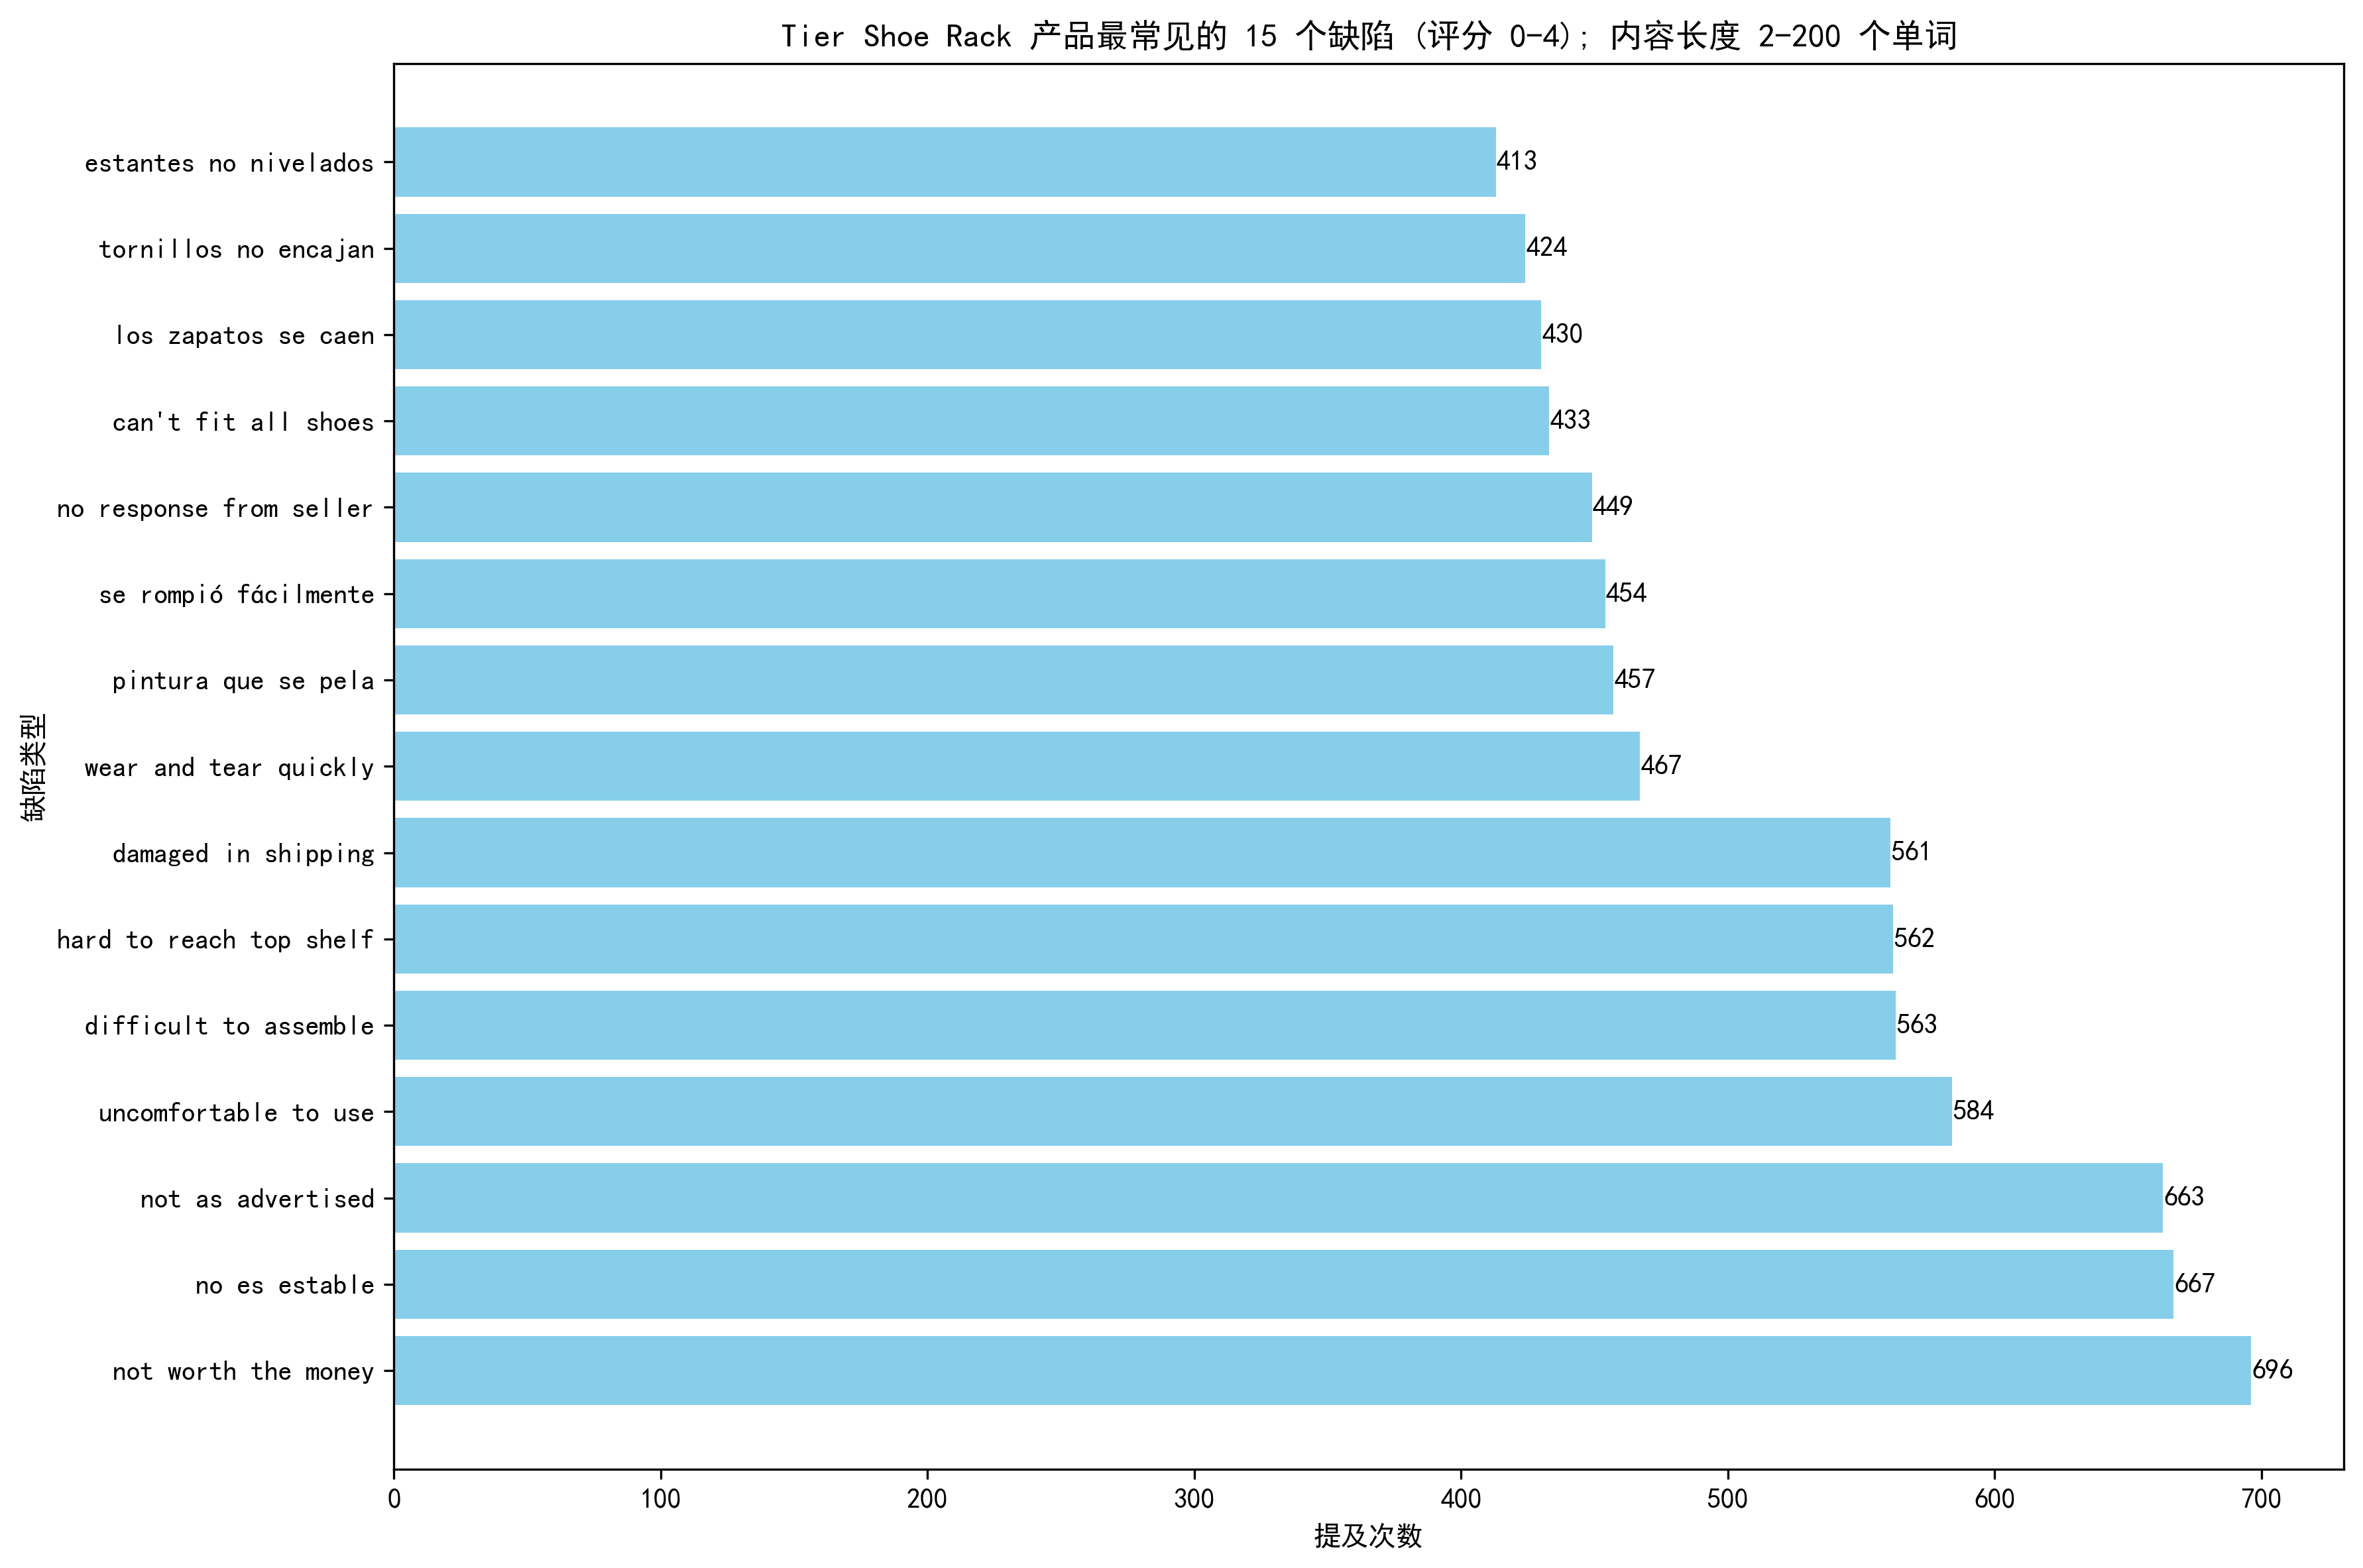


初始缺陷分析完成，耗时: 12.23 秒

分析条件:
- 产品类型: Tier Shoe Rack
- 评分范围: 0-4
- 内容长度: 2-200 个单词

初始缺陷频率分析结果:


,Defect,Count,Avg_Rating,Frequency
0,not worth the money,696,2.337644,0.035438
1,no es estable,667,2.316342,0.033961
2,not as advertised,663,2.303167,0.033758
3,uncomfortable to use,584,2.433219,0.029735
4,difficult to assemble,563,2.428064,0.028666
5,hard to reach top shelf,562,2.434164,0.028615
6,damaged in shipping,561,2.285205,0.028564
7,wear and tear quickly,467,2.464668,0.023778
8,pintura que se pela,457,2.468271,0.023269
9,se rompió fácilmente,454,2.473568,0.023116


使用utf-8-sig编码读取CSV文件失败: 'utf-8' codec can't decode byte 0xf8 in position 14: invalid start byte，尝试使用utf-8编码
使用utf-8编码读取CSV文件失败: Error tokenizing data. C error: Expected 1 fields in line 10, saw 2
，尝试使用GBK编码
所有CSV读取方式都失败: 'gbk' codec can't decode byte 0xa7 in position 16: illegal multibyte sequence，尝试读取Excel文件
尝试读取Excel文件: 生成结果\defect_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_2_to_200_words_defects_analysis.xlsx
成功读取Excel文件



已从保存的文件中删除Context列并转换为Excel格式

初始分析结果已保存到:
分析结果: 生成结果\defect_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_2_to_200_words_defects_analysis.xlsx
图表: 生成结果\defect_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_2_to_200_words_defects_chart.png


In [15]:
import os
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from IPython.display import display
from tqdm.notebook import tqdm  # Jupyter环境中使用tqdm
import glob

# 设置基本参数
def find_voc_file():
    # 查找Data文件夹中所有以"VOC数据.xlsx"结尾的文件
    voc_files = glob.glob("Data/*VOC数据.xlsx")
    
    if voc_files:
        # 如果找到多个匹配的文件，返回最新的一个（按文件修改时间排序）
        return sorted(voc_files, key=os.path.getmtime, reverse=True)[0]
    else:
        # 如果没有找到匹配的文件，抛出错误
        raise FileNotFoundError("未找到任何以'VOC数据.xlsx'结尾的文件")

# 保持原始变量名不变
file_path = find_voc_file()
print(f"使用的文件路径: {file_path}")

with open('Data/产品类别.txt', 'r', encoding='utf-8') as f:
    product_type = f.read().strip()

# 3. 验证变量内容
print(f"product_type变量的值为: '{product_type}'")
print(f"变量类型: {type(product_type)}")
rating_range = (0, 4)  # 可以根据需要修改或设为None
content_length_range = (2, 200)  # 最小10个单词，最大200个单词
content_length_method = 'words'  # 'words'计算单词数，'chars'计算字符数
content_column = 'content'  # 内容列名

# 步骤1: 初始缺陷分析
print("===== 第一阶段：初始缺陷识别 =====")
start_time = time.time()
# 读取原始数据
try:
    print(f"尝试读取Excel文件: {file_path}...")
    try:
        # 首先尝试读取Excel文件
        original_df = pd.read_excel(file_path)
        print(f"成功读取Excel文件")
    except Exception as ex:
        print(f"读取Excel文件失败: {str(ex)}")
        print("尝试作为CSV文件读取...")
        
        # 如果Excel读取失败，尝试多种编码读取为CSV
        encodings = ['utf-8', 'gbk', 'gb18030', 'latin1']
        original_df = None
        
        for encoding in encodings:
            try:
                print(f"尝试使用 {encoding} 编码读取CSV文件...")
                original_df = pd.read_csv(file_path, encoding=encoding)
                print(f"成功使用 {encoding} 编码读取CSV文件")
                break
            except UnicodeDecodeError:
                print(f"使用 {encoding} 编码读取失败")
                continue
            except Exception as ex:
                print(f"读取时发生其他错误: {str(ex)}")
                continue
        
        if original_df is None:
            # 最后的尝试：使用errors='replace'参数
            try:
                print("尝试使用 'utf-8' 编码和 errors='replace' 参数读取CSV...")
                original_df = pd.read_csv(file_path, encoding='utf-8', errors='replace')
                print("成功读取CSV文件，但某些字符可能已被替换")
            except Exception as ex:
                print(f"所有读取方法均失败: {str(ex)}")
                sys.exit(1)
    
    print(f"原始数据包含 {len(original_df)} 条记录")
except Exception as ex:
    print(f"读取文件时发生未预期错误: {str(ex)}")
    sys.exit(1)


# 创建进度条
with tqdm(total=100, desc="正在分析产品缺陷") as pbar:
    def update_progress(progress):
        pbar.update(progress - pbar.n)
    
    # 在主调用代码中启用调试模式
    results = analyze_product_defects(
    file_path=file_path, 
    product_type=product_type, 
    rating_range=rating_range,
    content_length_range=content_length_range,
    content_length_method=content_length_method,
    content_column=content_column,
    debug_mode=False,  # 启用调试模式
    progress_callback=update_progress
    )
    
    # 确保进度条到达100%
    pbar.update(100 - pbar.n)

end_time = time.time()
print(f"\n初始缺陷分析完成，耗时: {end_time - start_time:.2f} 秒")

# 显示筛选条件
print(f"\n分析条件:")
print(f"- 产品类型: {product_type}")
if rating_range:
    print(f"- 评分范围: {rating_range[0]}-{rating_range[1]}")
if content_length_range:
    min_len = content_length_range[0] if content_length_range[0] is not None else "任意"
    max_len = content_length_range[1] if content_length_range[1] is not None else "任意" 
    unit = "个字符" if content_length_method == "chars" else "个单词"
    print(f"- 内容长度: {min_len}-{max_len} {unit}")

# 显示初始结果
print("\n初始缺陷频率分析结果:")
# 在初始缺陷分析结果部分
if results and results.get('success') and 'defect_stats' in results and len(results.get('defect_stats', [])) > 0:
    # 显示结果（包含Context列）
    display(results['defect_stats'].head(10))  # 只显示前10条
    
    # 从保存路径读取完整的CSV文件
    csv_path = results['files']['result']
    if os.path.exists(csv_path):
        # 读取CSV，删除Context列，然后重新保存为xlsx
#        df = pd.read_csv(csv_path, encoding='utf-8-sig')
        try:
            df = pd.read_csv(csv_path, encoding='utf-8-sig')
        except Exception as e:
            print(f"使用utf-8-sig编码读取CSV文件失败: {str(e)}，尝试使用utf-8编码")
            try:
                df = pd.read_csv(csv_path, encoding='utf-8')
            except Exception as e2:
                print(f"使用utf-8编码读取CSV文件失败: {str(e2)}，尝试使用GBK编码")
                try:
                    df = pd.read_csv(csv_path, encoding='gbk')
                except Exception as e3:
                    print(f"所有CSV读取方式都失败: {str(e3)}，尝试读取Excel文件")
                    # 尝试读取对应的Excel文件
                    xlsx_path = os.path.splitext(csv_path)[0] + ".xlsx"
                    if os.path.exists(xlsx_path):
                        print(f"尝试读取Excel文件: {xlsx_path}")
                        df = pd.read_excel(xlsx_path)
                        print("成功读取Excel文件")
                    else:
                        print(f"Excel文件不存在: {xlsx_path}")
                        raise Exception("无法读取文件，所有尝试都失败")

        if 'Context' in df.columns:
            df = df.drop(columns=['Context'])
        
        # 将文件路径从.csv改为.xlsx
        xlsx_path = os.path.splitext(csv_path)[0] + ".xlsx"
        # 保存为Excel格式
        df.to_excel(xlsx_path, index=False)
        
        # 更新结果文件路径
        results['files']['result'] = xlsx_path
        print(f"\n已从保存的文件中删除Context列并转换为Excel格式")
    
    print(f"\n初始分析结果已保存到:")
    print(f"分析结果: {results['files']['result']}")
    print(f"图表: {results['files']['chart']}")
else:
    error_msg = results.get('error', "未知错误") if results else "分析未返回结果"
    print(f"没有找到任何产品缺陷信息: {error_msg}")
    print("将继续使用QWen-Max进行分析...")
    
    # 创建一个临时结果，避免程序崩溃
    if not results or not results.get('success'):
        # 创建临时Excel文件用于QWen分析
        temp_dir = os.path.join("生成结果", "defect_analysis")
        os.makedirs(temp_dir, exist_ok=True)
        temp_file = os.path.join(temp_dir, f"temp_defects_analysis.xlsx")
        
        # 创建一个简单的数据框，不包含Context列
        temp_df = pd.DataFrame({
            'Defect': ['缺陷识别失败'],
            'Count': [0],
            'Frequency': [0],
            'Avg_Rating': [0],
            'Review_Indices': [[]],
            'ReviewText': [[]]
            # Context列已被删除
        })
        temp_df.to_excel(temp_file, index=False)
        
        # 创建临时结果字典
        results = {
            'defect_stats': temp_df,
            'defect_df': pd.DataFrame(),
            'files': {'result': temp_file, 'chart': None},
            'save_path': temp_file,
            'success': True
        }




===== 第二阶段：QWen-Max精确筛选 =====


QWen-Max客户端初始化成功


QWen-Max正在筛选缺陷数据:   0%|          | 0/100 [00:00<?, ?it/s]

开始精炼缺陷分析结果...
从文件读取完整数据: 生成结果\defect_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_2_to_200_words_defects_analysis.xlsx
从文件读取完整数据: 生成结果\defect_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_2_to_200_words_defects_analysis.xlsx
尝试读取Excel文件: 生成结果\defect_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_2_to_200_words_defects_analysis.xlsx
成功读取Excel文件
成功从CSV读取的列: ['Defect', 'Count', 'Frequency', 'Avg_Rating', 'Importance_Score', 'Review_Indices', 'ReviewText']
使用QWen-Max筛选有意义的产品缺陷...
筛选前数据框列: ['Defect', 'Count', 'Frequency', 'Avg_Rating', 'Importance_Score', 'Review_Indices', 'ReviewText']


QWen-Max返回: [3, 5, 6, 7, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 207, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 2

,Defect,Count,Frequency,Avg_Rating,Importance_Score,Review_Indices,ReviewText
3,hard to reach top shelf,562,0.028615,2.434164,456.073478,"[4, 9, 21, 37, 38, 44, 47, 50, 51, 54, 56, 60,...","[""I have to be honest I'm sorry it seemed like..."
5,damaged in shipping,561,0.028564,2.285205,429.695339,"[4, 9, 11, 13, 21, 37, 38, 42, 44, 47, 50, 51,...","[""I have to be honest I'm sorry it seemed like..."
6,difficult to assemble,563,0.028666,2.428064,428.874121,"[4, 9, 21, 37, 38, 44, 47, 50, 51, 54, 56, 60,...","[""I have to be honest I'm sorry it seemed like..."
7,wear and tear quickly,467,0.023778,2.464668,371.455285,"[4, 9, 13, 37, 47, 50, 51, 54, 56, 66, 67, 68,...","[""I have to be honest I'm sorry it seemed like..."
11,se rompió fácilmente,454,0.023116,2.473568,343.476650,"[4, 9, 13, 31, 37, 38, 47, 50, 51, 54, 60, 66,...","[""I have to be honest I'm sorry it seemed like..."
12,los zapatos se caen,430,0.021894,2.453488,339.208998,"[4, 13, 31, 37, 38, 47, 50, 51, 54, 60, 66, 67...","[""I have to be honest I'm sorry it seemed like..."
15,no soporta mucho peso,408,0.020774,2.159314,326.485566,"[4, 29, 37, 42, 44, 47, 48, 50, 51, 54, 67, 69...","[""I have to be honest I'm sorry it seemed like..."
16,tornillos no encajan,424,0.021589,2.160377,325.175009,"[4, 9, 29, 37, 42, 44, 47, 48, 50, 51, 54, 67,...","[""I have to be honest I'm sorry it seemed like..."
17,estantes no nivelados,413,0.021029,2.152542,316.588978,"[4, 9, 29, 37, 42, 44, 47, 48, 50, 51, 54, 67,...","[""I have to be honest I'm sorry it seemed like..."
18,shelves not level,410,0.020876,2.204878,315.644723,"[4, 9, 29, 37, 42, 47, 48, 50, 51, 54, 67, 69,...","[""I have to be honest I'm sorry it seemed like..."



二次筛选的结果已保存到: 生成结果\defect_analysis\refined_致欧-2025-01-10之后VOC数据_rating_0_to_4_length_2_to_200_words_defects_analysis.xlsx


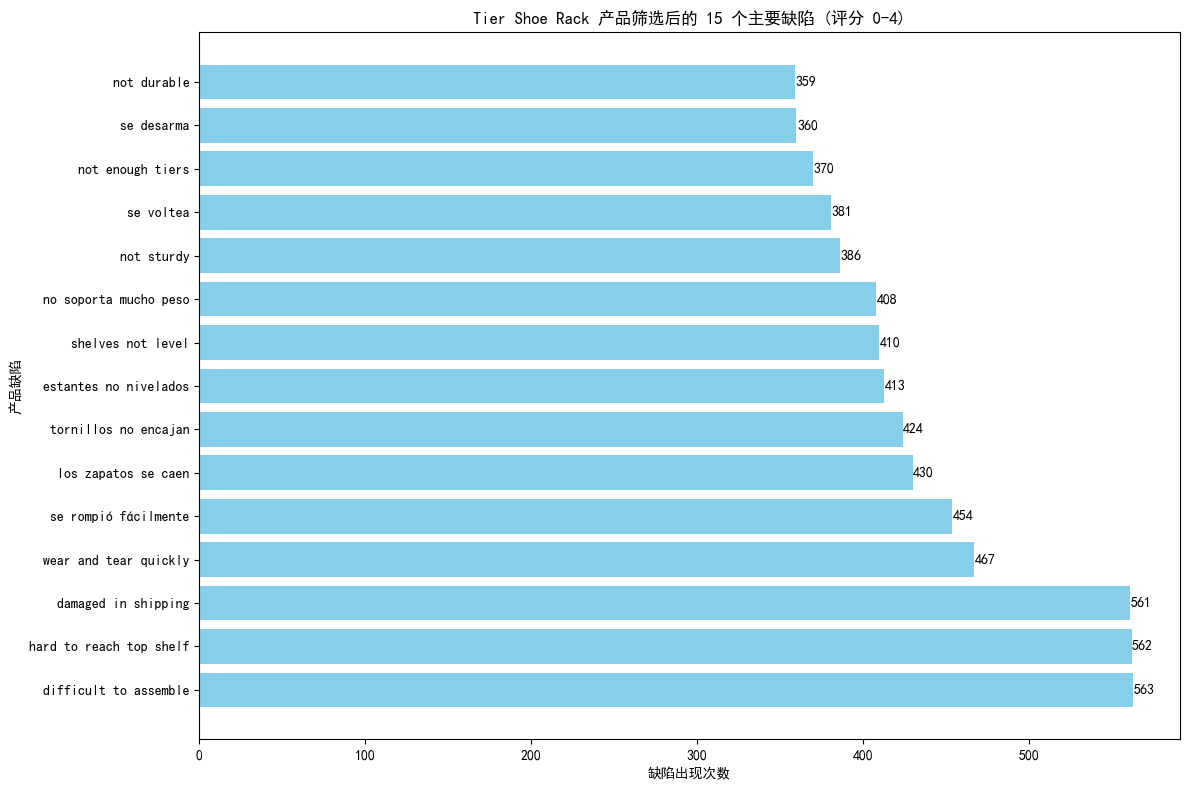

精选缺陷图表已保存到: 生成结果\defect_analysis\refined_致欧-2025-01-10之后VOC数据_rating_0_to_4_length_2_to_200_words_defects_analysis_chart.png

===== 缺陷分析流程完成 =====


In [16]:
# 步骤2: QWen-Max高级筛选
print("\n===== 第二阶段：QWen-Max精确筛选 =====")
start_time = time.time()

# 初始化QWen客户端
qwen_client = None
language = "english"  # 根据需要修改语言

try:
    # 从环境变量或配置文件中获取API密钥
    import os
    api_key = os.environ.get("QWEN_API_KEY") or API_KEY  # 假设API_KEY已在其他地方定义
    
    # 初始化OpenAI兼容的客户端
    if api_key:
        from openai import OpenAI
        qwen_client = OpenAI(
            api_key=api_key,  # 不需要引号，这是变量
            base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
        )
        print("QWen-Max客户端初始化成功")
    else:
        print("警告: 未找到API密钥，将跳过QWen-Max筛选")
        
except Exception as e:
    print(f"QWen-Max客户端初始化失败: {str(e)}")
    qwen_client = None

# 创建第二个进度条
with tqdm(total=100, desc="QWen-Max正在筛选缺陷数据") as pbar:
    # 假设refine_latest_defects_analysis函数支持回调以更新进度条
    def update_progress(progress):
        pbar.update(progress - pbar.n)
    
    refined_results = refine_latest_defects_analysis(
        results=results, 
        progress_callback=update_progress,
        qwen_client=qwen_client,
        language=language
    )
    
    # 确保进度条到达100%
    pbar.update(100 - pbar.n)

end_time = time.time()
print(f"\nQWen-Max筛选完成，耗时: {end_time - start_time:.2f} 秒")

# 显示筛选后的结果
if refined_results:
    print("\nQWen-Max筛选后的结果概览:")
    if 'defects_stats' in refined_results and refined_results['defects_stats'] is not None:
        display(refined_results['defects_stats'].head(10))  # 只显示前10条
    print(f"\n二次筛选的结果已保存到: {refined_results['save_path']}")

    # 使用'Defect'和'Count'列绘制柱状图
    if 'defects_stats' in refined_results and len(refined_results['defects_stats']) > 0:
        defects_df = refined_results['defects_stats']
        
        # 确保Defect和Count列存在
        if 'Defect' in defects_df.columns and 'Count' in defects_df.columns:
            # 尝试获取中文字体
            try:
                for font_name in ['SimHei', 'Microsoft YaHei', 'SimSun', 'Arial Unicode MS']:
                    try:
                        font = FontProperties(family=font_name)
                        plt.rcParams['font.family'] = font_name
                        break
                    except:
                        continue
            except:
                pass  # 如果无法设置中文字体，使用默认字体
                
            # 对数据按Count列排序，取前15个
            top_n = min(15, len(defects_df))
            top_defects = defects_df.sort_values('Count', ascending=False).head(top_n)
            
            plt.figure(figsize=(12, 8))
            bars = plt.barh(top_defects['Defect'], top_defects['Count'], color='skyblue')
            plt.xlabel('缺陷出现次数')
            plt.ylabel('产品缺陷')
            
            title = f'{product_type} 产品筛选后的 {top_n} 个主要缺陷'
            if rating_range:
                title += f' (评分 {rating_range[0]}-{rating_range[1]})'
            plt.title(title)
            
            plt.tight_layout()
            
            # 在每个条形上添加计数标签
            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.3, bar.get_y() + bar.get_height()/2, 
                         f'{width:.0f}', ha='left', va='center')
            
            # 保存精选缺陷图表
            refined_chart_file = os.path.splitext(refined_results['save_path'])[0] + "_chart.png"
            plt.savefig(refined_chart_file, dpi=300, bbox_inches='tight')
            
            # 显示图表
            plt.show()
            print(f"精选缺陷图表已保存到: {refined_chart_file}")
        else:
            print(f"警告: 无法绘制图表 - 缺少必要的列。现有列: {defects_df.columns.tolist()}")
else:
    print("QWen-Max筛选未产生有效结果")

print("\n===== 缺陷分析流程完成 =====")